In [592]:
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option("display.max_columns", None)
import warnings
warnings.filterwarnings("ignore")


from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

#modelos y evaluación
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression


In [415]:
df = pd.read_csv("Dataset/Series9700.csv")
df.shape

(9695, 27)

In [416]:
df["Title"]= df["Title"].str.lower()


In [417]:
# elimnamos duplicados
df[df.duplicated(subset= ["Title", "Origin Country", "First Air Date"], keep=False)] 


Unnamed: 0            Title  \
6517        6517  forensic heroes   
7300        7300  forensic heroes   

                                               Synopsis Tagline        Genero  \
6517  Forensic Heroes is a series of TVB police proc...     NaN  Drama, Crime   
7300  Follows a group of Hong Kong forensic scientis...     NaN  Crime, Drama   

      Rating  Popularity  Vote Count  Vote Average Original Language  \
6517     9.0      62.695           2           9.0                cn   
7300     7.6      57.454          11           7.6                cn   

     Origin Country First Air Date  Last Air Date  In production  \
6517             HK     2006-06-13            NaN           True   
7300             HK     2006-06-13            NaN          False   

                Status  Number of Season  Number of Episodes  \
6517  Returning Series                 6                 169   
7300             Ended                 1                  25   

      Episode Duration Production Companies Where to Watch     Reviews  \
6517              45.0                  TVB           KKTV  No reviews   
7300              45.0                  TVB           KKTV  No reviews   

                 Budget            Revenue  \
6517  No data available  No data available   
7300  No data available  No data available   

                                                   Cast       Creators  \
6517  Bosco Wong Chung-Chak, Jacky Cai, Benjamin Yue...  Mui Siu-Ching   
7300  Bobby Au-Yeung Tsan-Wah, Yoyo Mung Ka-Wai, Fra...  Mui Siu-Ching   

                                                 Poster               Trailer  
6517  https://image.tmdb.org/t/p/w500/mI2IpGSvN2HD0l...  No trailer available  
7300  https://image.tmdb.org/t/p/w500/yOfvmuKBv8yeep...  No trailer available

In [418]:
df = df.drop_duplicates(subset="Title", keep="first") # me quedo con los primeros

In [419]:
df.shape 

(9420, 27)

In [420]:
# Checking for null values
nulls = pd.DataFrame(df.isna().sum()/len(df))
nulls= nulls.reset_index()
nulls.columns = ['column_name', 'Percentage Null Values']
nulls.sort_values(by='Percentage Null Values', ascending = False)

column_name  Percentage Null Values
12         Last Air Date                1.000000
3                Tagline                0.851486
24              Creators                0.487367
18  Production Companies                0.249894
2               Synopsis                0.167941
4                 Genero                0.055414
23                  Cast                0.054034
11        First Air Date                0.003503
0             Unnamed: 0                0.000000
16    Number of Episodes                0.000000
25                Poster                0.000000
22               Revenue                0.000000
21                Budget                0.000000
20               Reviews                0.000000
19        Where to Watch                0.000000
17      Episode Duration                0.000000
13         In production                0.000000
15      Number of Season                0.000000
14                Status                0.000000
1                  Title                0.000000
10        Origin Country                0.000000
9      Original Language                0.000000
8           Vote Average                0.000000
7             Vote Count                0.000000
6             Popularity                0.000000
5                 Rating                0.000000
26               Trailer                0.000000

In [421]:
df.drop(columns=["Unnamed: 0", "Tagline", "Vote Average", "Last Air Date", "Production Companies","Budget", "Revenue", "Cast", "Creators", "Poster", "Trailer"], inplace=True)

In [422]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9420 entries, 0 to 9694
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Title               9420 non-null   object 
 1   Synopsis            7838 non-null   object 
 2   Genero              8898 non-null   object 
 3   Rating              9420 non-null   float64
 4   Popularity          9420 non-null   float64
 5   Vote Count          9420 non-null   int64  
 6   Original Language   9420 non-null   object 
 7   Origin Country      9420 non-null   object 
 8   First Air Date      9387 non-null   object 
 9   In production       9420 non-null   bool   
 10  Status              9420 non-null   object 
 11  Number of Season    9420 non-null   int64  
 12  Number of Episodes  9420 non-null   int64  
 13  Episode Duration    9420 non-null   float64
 14  Where to Watch      9420 non-null   object 
 15  Reviews             9420 non-null   object 
dtypes: bool(1),

In [423]:
# convierto el first air date a date time 
df["First Air Date"] = pd.to_datetime(df["First Air Date"])
# creo una columna con el año y me cargo la fecha
df["release_year"] = df["First Air Date"].dt.year
df.drop(columns = "First Air Date", inplace=True)


In [424]:
num = ["Rating", "Popularity", "Vote Count", "Number of Season", "Number of Episodes", "Episode Duration", "release_year"]


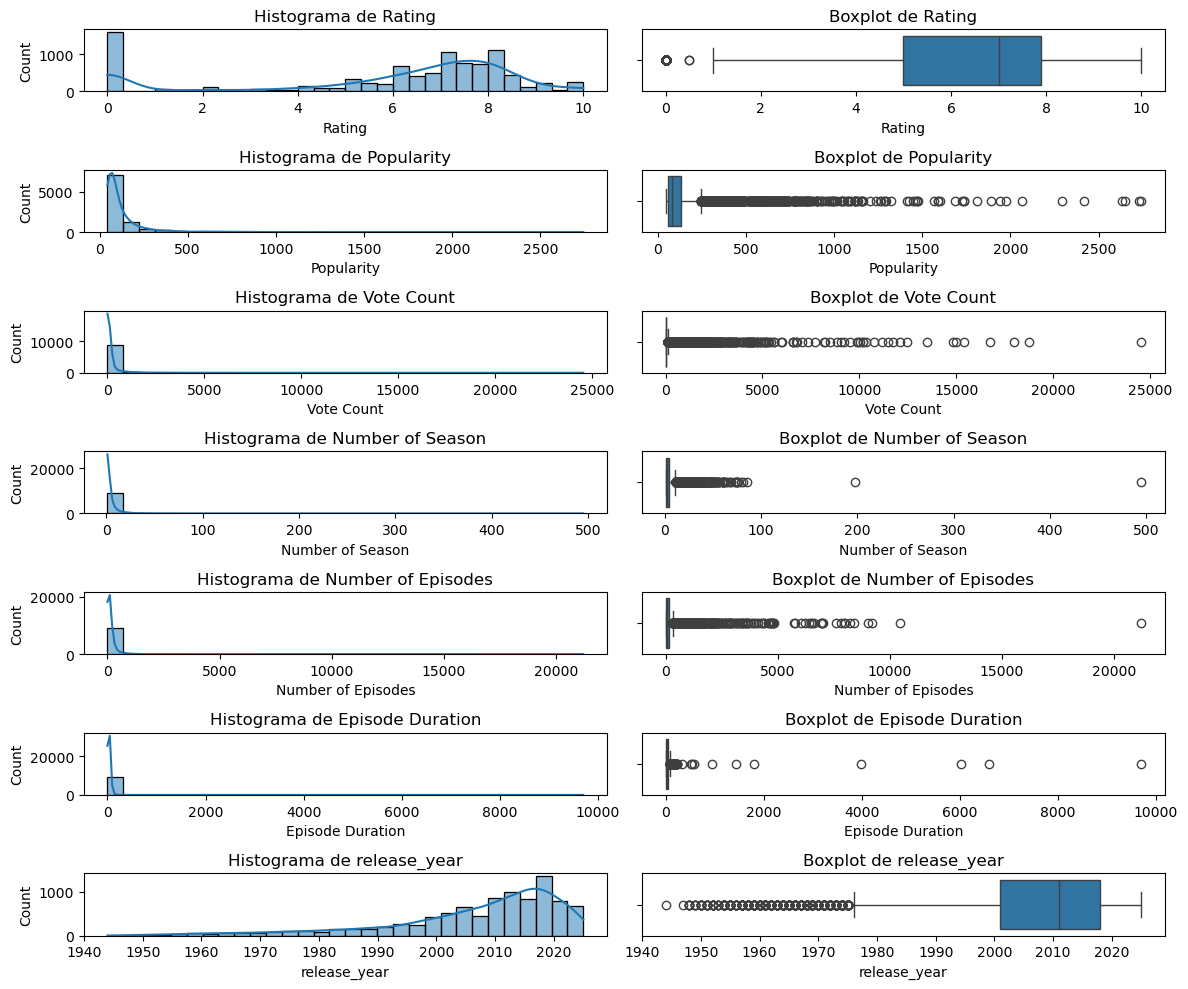

In [425]:
plt.figure(figsize=(12, 10))
for i, column in enumerate(num, 1):
    plt.subplot(len(num), 2, i*2-1)
    sns.histplot(df[column], bins = 30, kde = True)
    plt.title(f"Histograma de {column}")

    plt.subplot(len(num), 2, i*2)
    sns.boxplot(x=df[column])
    plt.title(f"Boxplot de {column}")

plt.tight_layout()
plt.show()

### RATING

In [426]:
# vemos los outliers
iqr = np.percentile(df["Rating"],75) - np.percentile(df["Rating"],25)
upper_limit = np.percentile(df["Rating"],75) + 1.5*iqr
lower_limit = np.percentile(df["Rating"],25) - 1.5*iqr
print(upper_limit)
print(lower_limit)

12.25
0.6499999999999995


In [427]:
df[df["Rating"] == 0] # 1581 con 0

Title  \
23                         secret story - desafio final   
31                                     choti sarrdaarni   
36                                              hk 80's   
44                                    comedy big league   
56                                     a kindred spirit   
82                                       hashir shelanu   
89                                       barrister babu   
90                                              omusubi   
110                                 sabine christiansen   
111                                       die anrheiner   
185                              hometown over the hill   
200                           the gold behind the stone   
201                               mind our own business   
212                                     style challenge   
217                         downtown no gottsu ee kanji   
218                                                 kin   
219                                      kotowaza house   
232                                  rude miss young ae   
267                                             haalufa   
277                                        blockbusters   
286                                city japes july 1987   
288                                             ninosan   
292                                       phoenix runde   
298                                               kesar   
301                                              shagun   
311                                       krejlerkongen   
314                                       hallo kroket!   
329                                       bizarre bunch   
338               kamisama minarai: himitsu no cocotama   
342                                      bindiya sarkar   
353                               cool kiz on the block   
361                                   super trio series   
367                                 when the sun shines   
370                                            jiji maa   
372                                   nieuws van de dag   
391                                          encantadia   
399                                            parichay   
407                                         ashita koso   
429                                              dumont   
430                   makeover! dramatic before & after   
433                               karmaphal daata shani   
443                                      hello! morning   
454                                          dondo hare   
467                                                zone   
485                           the meaning of friendship   
491                                         the seasons   
497                                      münchner runde   
510                                            honmamon   
511                                       marina orsini   
513                                    die montagsmaler   
516                                           im dialog   
525                                            ohanahan   
537                               tamagon the counselor   
544                                       lara's choice   
548                                                agri   
549                                   karam apnaa apnaa   
565                                       hatoko no umi   
597                                      ashita no kaze   
600                                      infinite girls   
604                                        ai yori aoku   
605                                      spécial cinéma   
606                                   memphis wrestling   
608                                     quizduell-olymp   
610                                       mayuko hitori   
613                                         a impostora   
619                                              hirari   
620                                      scarlet letter   
638                                   

In [428]:
# los elimino
df = df[df["Rating"]!= 0]


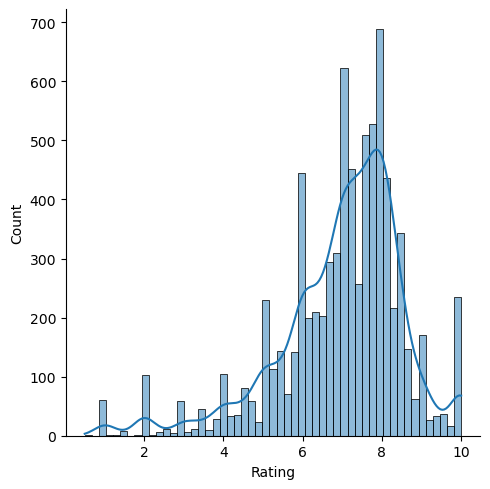

In [429]:
sns.displot(df["Rating"], kde = True)
plt.show()

In [430]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7839 entries, 0 to 9694
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Title               7839 non-null   object 
 1   Synopsis            6889 non-null   object 
 2   Genero              7609 non-null   object 
 3   Rating              7839 non-null   float64
 4   Popularity          7839 non-null   float64
 5   Vote Count          7839 non-null   int64  
 6   Original Language   7839 non-null   object 
 7   Origin Country      7839 non-null   object 
 8   In production       7839 non-null   bool   
 9   Status              7839 non-null   object 
 10  Number of Season    7839 non-null   int64  
 11  Number of Episodes  7839 non-null   int64  
 12  Episode Duration    7839 non-null   float64
 13  Where to Watch      7839 non-null   object 
 14  Reviews             7839 non-null   object 
 15  release_year        7827 non-null   float64
dtypes: bool(1),

### POPULARITY

Text(0.5, 1.0, 'Boxplot')

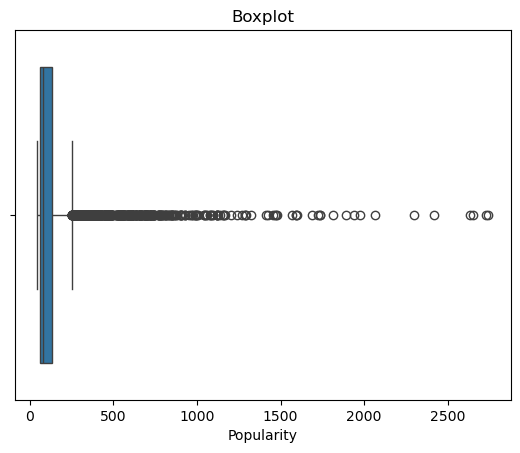

In [431]:
sns.boxplot(data = df, x="Popularity")
plt.title(f"Boxplot")

Text(0.5, 1.0, 'Histograma')

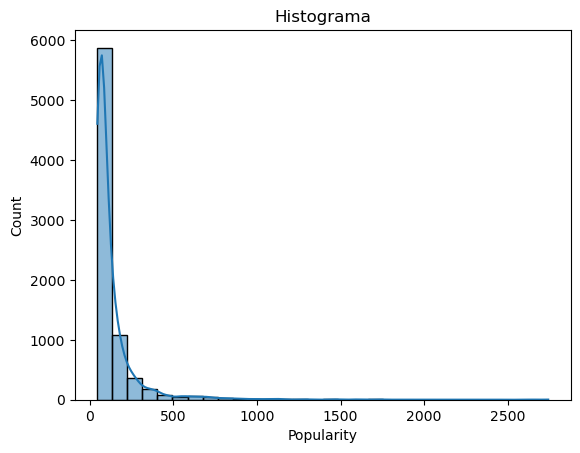

In [432]:
sns.histplot(data = df, x= "Popularity", bins = 30, kde = True)
plt.title(f"Histograma")

In [433]:
# Checking how many values will be removed if the outliers are removed
iqr = np.percentile(df["Popularity"],75) - np.percentile(df["Popularity"],25)
upper_limit = np.percentile(df["Popularity"],75) + 1.5*iqr
print(upper_limit)


249.463


In [434]:
removed = df[df["Popularity"] > upper_limit]
len(removed)  # This checks the number of outliers that will be removed, too many

757

In [435]:
df.loc[[df["Popularity"].idxmax()]]

Title Synopsis   Genero  Rating  Popularity  Vote Count Original Language  \
0  gh dúo      NaN  Reality     7.3    2742.445           3                es   

  Origin Country  In production            Status  Number of Season  \
0             ES           True  Returning Series                 3   

   Number of Episodes  Episode Duration Where to Watch     Reviews  \
0                 146             105.0         Tivify  No reviews   

   release_year  
0        2019.0

In [436]:
# no voy a eliminar los outliers, haré transformación

In [437]:
def log_transfom_clean_(x):
    if np.isfinite(x) and x!=0:
        return np.log(x)
    else:
        return np.NAN # 

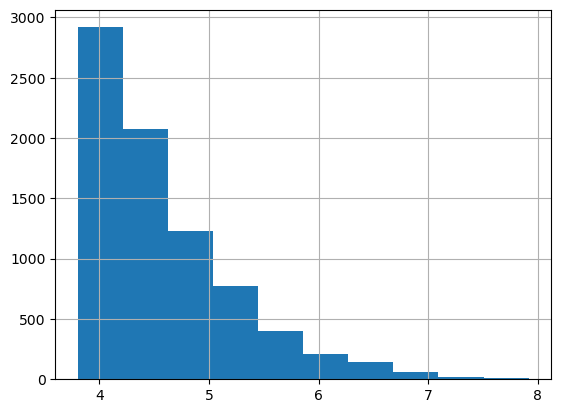

In [438]:
# Using the functions to check the distribution of transformed data
pd.Series(map(log_transfom_clean_, df['Popularity'])).hist()
plt.show()

In [439]:
def sqrt_transfom_clean_(x):
    if np.isfinite(x) and x>=0:
        return np.sqrt(x)
    else:
        return np.NAN # We are returning NaNs so that we can replace them later

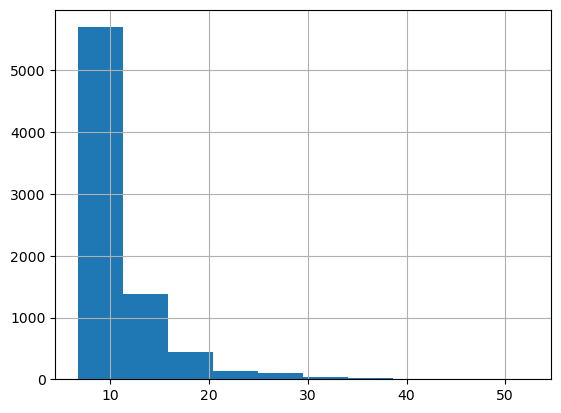

In [440]:
pd.Series(map(sqrt_transfom_clean_, df['Popularity'])).hist()
plt.show()

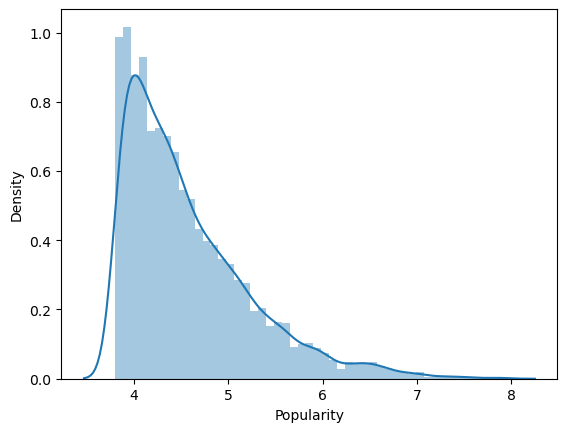

In [441]:
# me quedo con la logaritmo
# Use log transformation to replace the values of the column now
df['Popularity'] = list(map(log_transfom_clean_, df['Popularity']))
sns.distplot(df['Popularity'])
plt.show()

### VOTE COUNT

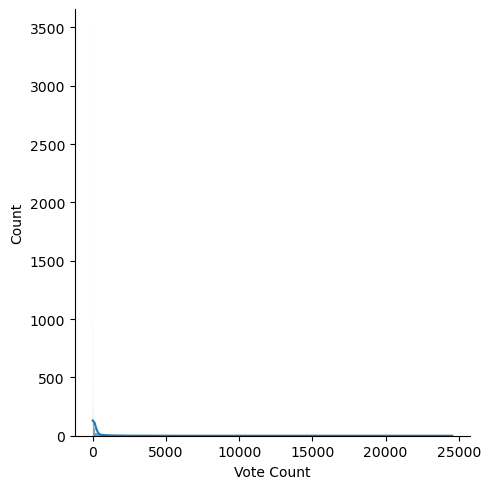

In [442]:
sns.displot(df["Vote Count"], kde = True)
plt.show()

In [443]:
# Checking how many values will be removed if the outliers are removed
iqr = np.percentile(df["Vote Count"],75) - np.percentile(df["Vote Count"],25)
upper_limit = np.percentile(df["Vote Count"],75) + 1.5*iqr
print(upper_limit)

200.5


In [444]:
removed = df[df["Vote Count"] > upper_limit]
len(removed)  # This checks the number of outliers that will be removed

1301

In [445]:
df.loc[[df["Vote Count"].idxmax()]]

Title                                           Synopsis  \
108  game of thrones  Seven noble families fight for control of the ...   

                                          Genero  Rating  Popularity  \
108  Sci-Fi & Fantasy, Drama, Action & Adventure     8.5    6.652225   

     Vote Count Original Language Origin Country  In production Status  \
108       24560                en             US          False  Ended   

     Number of Season  Number of Episodes  Episode Duration  \
108                 8                  73               0.0   

                                        Where to Watch  \
108  Sky X, Spectrum On Demand, Strim, Neon TV, Mov...   

                                               Reviews  release_year  
108  I started watching when it came out as I heard...        2011.0

In [446]:
# miro a ver si hay ceros
df[df["Vote Count"] == 0] # hay pocos, los elimino

Title  \
1556                 azul tequila   
2220                 erotas fygas   
2843                    quizduell   
4468  paul's miraculous adventure   
5778             family feud (hk)   
5966                daddy at home   
6821                 místo nahoře   
7796             masterchef korea   

                                               Synopsis  \
1556  Azul Tequila is a Mexican telenovela. The 80-e...   
2220  "Erotas Fygas" travels us to Greece in the 50'...   
2843                                                NaN   
4468  Paul is a young boy whose friend Nina is kidna...   
5778  Based off of American game show Family Feud, h...   
5966                                                NaN   
6821                                                NaN   
7796                                                NaN   

                                 Genero  Rating  Popularity  Vote Count  \
1556                              Drama     7.0    5.163105           0   
2220                              Drama     9.0    4.936242           0   
2843                            Reality     6.0    4.761977           0   
4468  Animation, Kids, Sci-Fi & Fantasy     6.0    4.428505           0   
5778                    Reality, Comedy    10.0    4.241787           0   
5966                    Reality, Family     7.0    4.215780           0   
6821                              Drama     7.0    4.105697           0   
7796                            Reality     8.0    3.995573           0   

     Original Language Origin Country  In production            Status  \
1556                es             MX          False             Ended   
2220                el             GR           True  Returning Series   
2843                de             DE           True  Returning Series   
4468                ja             JP          False             Ended   
5778                cn             HK           True  Returning Series   
5966                zh             CN           True  Returning Series   
6821                cs             CZ          False             Ended   
7796                ko             KR          False             Ended   

      Number of Season  Number of Episodes  Episode Duration  \
1556                 1                 160               0.0   
2220                 2                 260              60.0   
2843                 6                 219               0.0   
4468                 1                  50              21.0   
5778                 1                  69               0.0   
5966                 3                  82              90.0   
6821                 1                  13               0.0   
7796                 4                  51              50.0   

              Where to Watch     Reviews  release_year  
1556  No platforms available  No reviews        1998.0  
2220  No platforms available  No reviews        2022.0  
2843  No platforms available  No reviews        2014.0  
4468  No platforms available  No reviews        1976.0  
5778  No platforms available  No reviews        2021.0  
5966  No platforms available  No reviews        2022.0  
6821  No platforms available  No reviews        2004.0  
7796  No platforms available  No reviews        2012.0

In [447]:
df= df[df["Vote Count"]!=0]

In [448]:
df.loc[[df["Vote Count"].idxmin()]]

Title                                           Synopsis  \
22  centovetrine  The series tells the stories of some of the ch...   

         Genero  Rating  Popularity  Vote Count Original Language  \
22  Soap, Drama     6.0    7.283866           1                it   

   Origin Country  In production    Status  Number of Season  \
22             IT          False  Canceled                15   

    Number of Episodes  Episode Duration Where to Watch     Reviews  \
22                3318              20.0      Timvision  No reviews   

    release_year  
22        2001.0

In [449]:
# no voy a eliminar los outliers, haré transformación

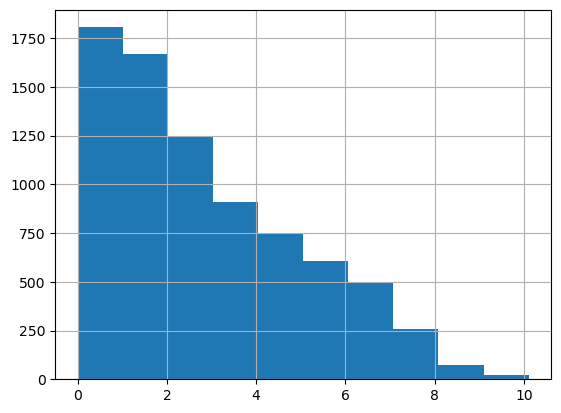

In [450]:
# Using the functions to check the distribution of transformed data
pd.Series(map(log_transfom_clean_, df['Vote Count'])).hist()
plt.show()

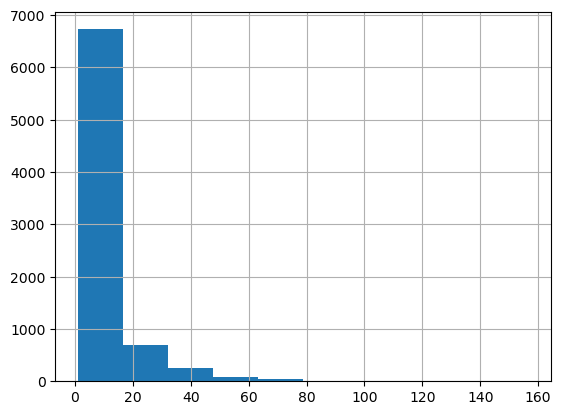

In [451]:
pd.Series(map(sqrt_transfom_clean_, df['Vote Count'])).hist()
plt.show()

In [452]:
# creo que me quedo con la transforamción logaritmo

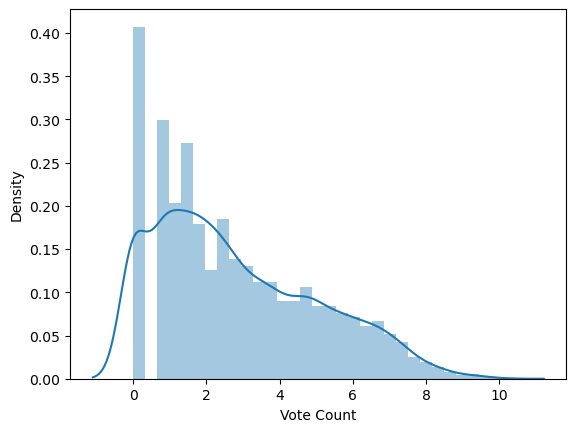

In [453]:
# Use log transformation to replace the values of the column now
df['Vote Count'] = list(map(log_transfom_clean_, df['Vote Count']))
sns.distplot(df['Vote Count'])
plt.show()

### NUMBER OF SEASONS

Text(0.5, 1.0, 'Histograma')

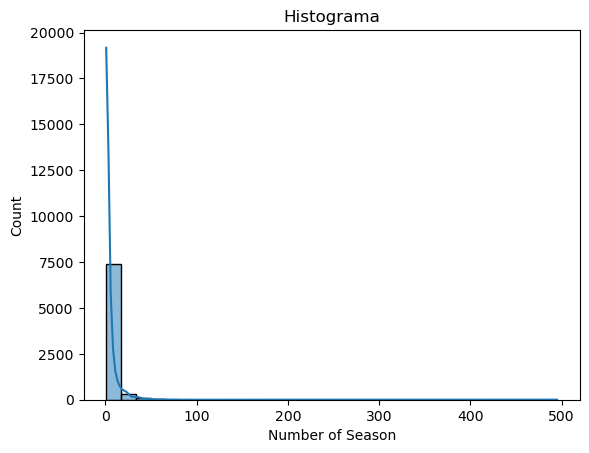

In [454]:
sns.histplot(data = df, x= "Number of Season", bins = 30, kde = True)
plt.title(f"Histograma")

Text(0.5, 1.0, 'Boxplot')

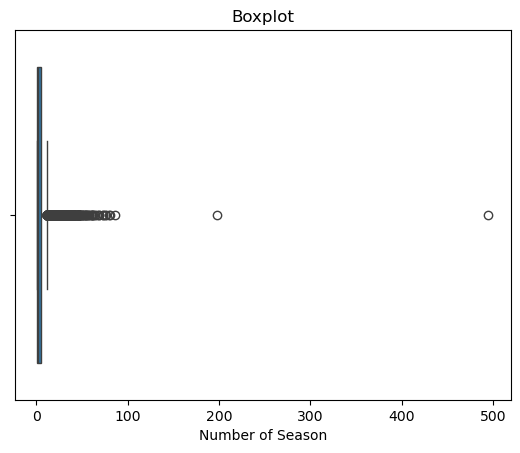

In [455]:
sns.boxplot(data = df, x="Number of Season")
plt.title(f"Boxplot")

In [456]:
df.loc[[df["Number of Season"].idxmax()]]

Title Synopsis             Genero  Rating  Popularity  \
5170  lecture room      NaN  Talk, Documentary    10.0    4.324834   

      Vote Count Original Language Origin Country  In production  \
5170         0.0                zh             CN           True   

                Status  Number of Season  Number of Episodes  \
5170  Returning Series               495                6947   

      Episode Duration          Where to Watch     Reviews  release_year  
5170               0.0  No platforms available  No reviews        2001.0

In [457]:
# eliminamos este outlier
df.drop(df[df["Number of Season"] == 495].index, inplace=True)

In [458]:
df.loc[df["Number of Season"]> 40].sort_values(by="Number of Season", ascending=False)
# es cierto que Pili tiene 86 temporadas 
# house hunters international tiene 198 temporadas 


Title  \
7620                      house hunters international   
4158                                             pili   
3881                              golden globe awards   
1319                                   meet the press   
3484                                        countdown   
3419                           sanremo music festival   
333                                          panorama   
472                                        tagesschau   
9617                          eurovision song contest   
2247                          have i got news for you   
18                                  coronation street   
4297                                 melodifestivalen   
9664                             the nature of things   
543                                  general hospital   
647                                       tony awards   
1361                                 match of the day   
5377                                          chopped   
434                                           horizon   
3289                                       60 minutes   
29                                  law of the jungle   
502                                scene of the crime   
170                                     sesame street   
8022                          new japan pro wrestling   
32                               university challenge   
263                                    polizeiruf 110   
34                                           der alte   
2573                                             nova   
3025                       the young and the restless   
3097                      diners, drive-ins and dives   
1593                              saturday night live   
2230                               great performances   
1587          alarm for cobra 11: the motorway police   
2791                                         3 nach 9   
159                                          survivor   
3147                                          le iene   
163                                          loona tv   
254                                        mastermind   
1452                          cbs news sunday morning   
2439                                    question time   
4109         viña del mar international song festival   
6082                               austin city limits   
562                                              fuse   
206                                 antiques roadshow   
3741                                   this old house   
152                                      soko münchen   
3958                                            arena   
1446                                         top gear   
244                                         frontline   
1015                                        löwenzahn   
1337                                  top of the pops   
1264                                    ndr talk show   
7220                                this is your life   
2601                                           nature   
4022                               the price is right   
178                                    ridiculousness   
5891                                 wheel of fortune   
1112                                         casualty   
7787                                   the sooty show   
3694                           mtv video music awards   
174                                        eastenders   
149                                         jeopardy!   
829   cctv spring festival gala: crosstalk and sketch   
179                                        neighbours   

                                               Synopsis  \
7620  This spin-off of the wildly popular House Hunt...   
4158  Pili is a puppet show from Taiwan. It is made ...   
3881  An annual awards ceremony recognizing excellen...   
1319  Meet the Press is a weekly American television...   
3484  The clock is ticking as contestants compete in...   
3419  The Sanremo Music Festival is the most 

In [459]:
# puede parecer raro pero sí, la serie diners, drive-ins and dives tiene 51 temporadas a pesar de haberse estrenado en 2007
# he revisado en internet y el número de temporadas de estas series es correcto
# HELL'S KITCHEN IGUAL, TIENE 23 TEMPORADAS Y SOLO SE ESTRENÓ EN 2005

In [460]:
df.loc[df["Title"] == "Le Iene", "Number of Season"]= 28

In [461]:
df.loc[df["Title"] == "Le Iene", "Number of Episodes"]= 938

In [462]:
df.loc[df["Title"] == "Alarm for Cobra 11: The Motorway Police", "Number of Season"]= 25

In [463]:
df.loc[[df["Number of Season"].idxmin()]] # el número mínimo de temporadas es 1

Title                                           Synopsis  \
4  running man  A reality and competition show where members a...   

            Genero  Rating  Popularity  Vote Count Original Language  \
4  Comedy, Reality     8.4    7.790279    5.192957                ko   

  Origin Country  In production            Status  Number of Season  \
4             KR           True  Returning Series                 1   

   Number of Episodes  Episode Duration  \
4                 739              85.0   

                                      Where to Watch     Reviews  release_year  
4  wavve, Rakuten Viki, Viu, OnDemandKorea, Watch...  No reviews        2010.0

In [464]:
# data in Number of Season is highly skewed. Let's try some transformations (again)

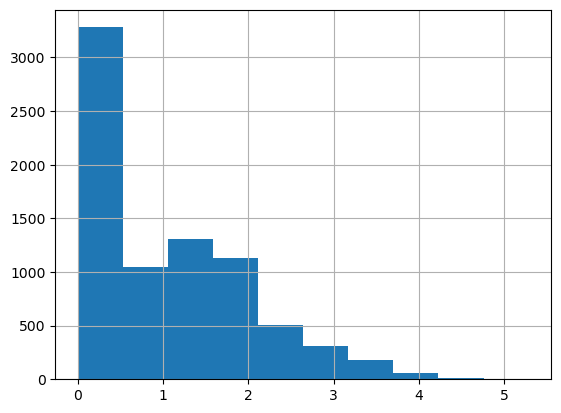

In [465]:
# Using the functions to check the distribution of transformed data
pd.Series(map(log_transfom_clean_, df['Number of Season'])).hist()
plt.show()

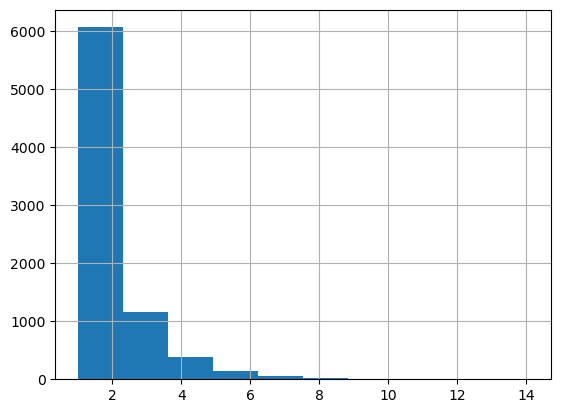

In [466]:
pd.Series(map(sqrt_transfom_clean_, df['Number of Season'])).hist()
plt.show()

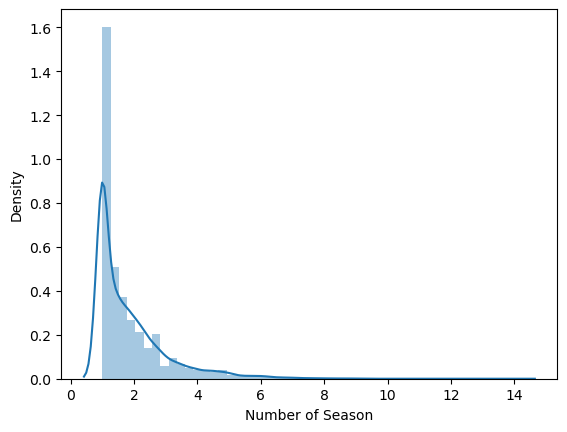

In [467]:
# Use sqrt transformation to replace the values of the column now
df['Number of Season'] = list(map(sqrt_transfom_clean_, df['Number of Season']))
sns.distplot(df['Number of Season'])
plt.show()

### NUMBER OF EPISODES

Text(0.5, 1.0, 'Histograma')

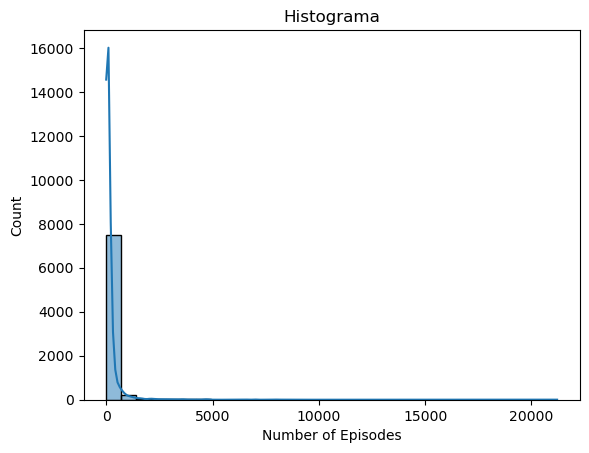

In [468]:
sns.histplot(data = df, x= "Number of Episodes", bins = 30, kde = True)
plt.title(f"Histograma")

In [469]:
# number of episodes también está highly skewed

In [470]:
df.loc[[df["Number of Episodes"].idxmin()]] 

Title                                           Synopsis Genero  \
6991  my mother  My Mother is an erotic manga by Thai artist XT...    NaN   

      Rating  Popularity  Vote Count Original Language Origin Country  \
6991     8.0    4.085438    0.693147                ja             JP   

      In production            Status  Number of Season  Number of Episodes  \
6991           True  Returning Series               1.0                   1   

      Episode Duration          Where to Watch     Reviews  release_year  
6991               0.0  No platforms available  No reviews        2023.0

In [471]:
# la elimino
df.drop(df[df["Title"]== "my mother"].index, inplace=True)

In [472]:
df.loc[[df["Number of Episodes"].idxmin()]] 

Title  \
1499  the leveling of solo leveling   

                                               Synopsis       Genero  Rating  \
1499  A two-part documentary that aims to explore th...  Documentary    10.0   

      Popularity  Vote Count Original Language Origin Country  In production  \
1499    5.185887         0.0                en             US          False   

     Status  Number of Season  Number of Episodes  Episode Duration  \
1499  Ended               1.0                   2              21.0   

                               Where to Watch     Reviews  release_year  
1499  Crunchyroll Amazon Channel, Crunchyroll  No reviews        2024.0

In [473]:
df.loc[[df["Number of Episodes"].idxmax()]] 

Title                                           Synopsis Genero  \
472  tagesschau  German daily news program, the oldest still ex...   News   

     Rating  Popularity  Vote Count Original Language Origin Country  \
472     6.8    5.887498     5.46806                de             DE   

     In production            Status  Number of Season  Number of Episodes  \
472           True  Returning Series          8.544004               21205   

     Episode Duration          Where to Watch     Reviews  release_year  
472              15.0  No platforms available  No reviews        1952.0

In [474]:
df.loc[df["Title"] == "tagesschau", "Number of Episodes"]= 366 # cambio el valor porque estaba mal /lo he buscado en internet

In [475]:
# elimino también la serie Among Friends porque no encuentro info de cuantos episodios tiene y me parecen demasiados
df.drop(df[df["Title"]== "among friends"].index, inplace = True)

In [476]:
df.loc[[df["Number of Episodes"].idxmin()]] 
# la serie más corta es the leveling of solo leveling, con 2 episodios

Title  \
1499  the leveling of solo leveling   

                                               Synopsis       Genero  Rating  \
1499  A two-part documentary that aims to explore th...  Documentary    10.0   

      Popularity  Vote Count Original Language Origin Country  In production  \
1499    5.185887         0.0                en             US          False   

     Status  Number of Season  Number of Episodes  Episode Duration  \
1499  Ended               1.0                   2              21.0   

                               Where to Watch     Reviews  release_year  
1499  Crunchyroll Amazon Channel, Crunchyroll  No reviews        2024.0

Text(0.5, 1.0, 'Boxplot')

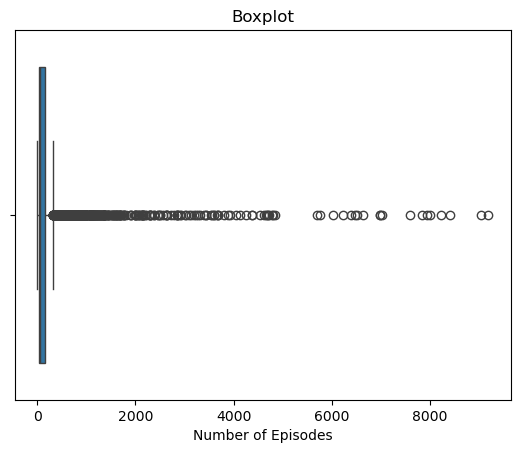

In [477]:
sns.boxplot(data = df, x="Number of Episodes")
plt.title(f"Boxplot")

In [478]:
# Checking how many values will be removed if the outliers are removed
iqr = np.percentile(df["Number of Episodes"],75) - np.percentile(df["Number of Episodes"],25)
upper_limit = np.percentile(df["Number of Episodes"],75) + 1.5*iqr
print(upper_limit)

324.375


In [479]:
removed = df[df["Number of Episodes"] > upper_limit]
len(removed)  # This checks the number of outliers that will be removed, too many

817

In [480]:
df.loc[df["Title"] == "the tonight show starring johnny carson", "Number of Episodes"]= 6714

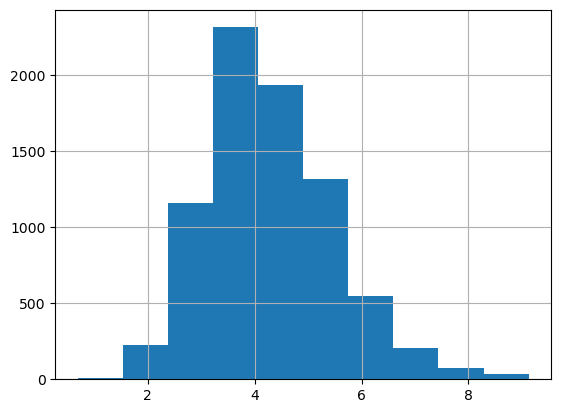

In [481]:
# Using the functions to check the distribution of transformed data
pd.Series(map(log_transfom_clean_, df["Number of Episodes"])).hist()
plt.show()

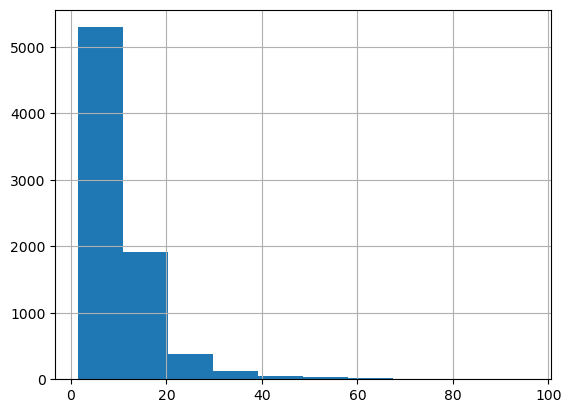

In [482]:
pd.Series(map(sqrt_transfom_clean_, df["Number of Episodes"])).hist()
plt.show()

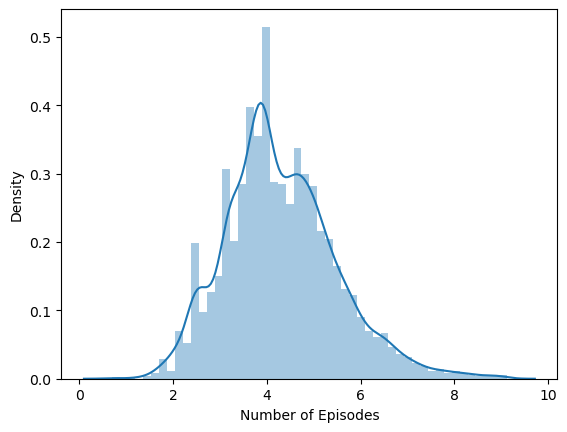

In [483]:
# Use log transformation to replace the values of the column now
df["Number of Episodes"] = list(map(log_transfom_clean_, df["Number of Episodes"]))
sns.distplot(df["Number of Episodes"])
plt.show()

### EPISODE DURATION

Text(0.5, 1.0, 'Histograma')

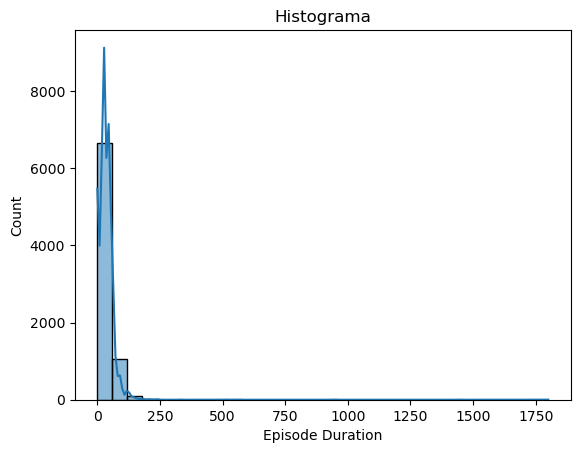

In [484]:
sns.histplot(data = df, x= "Episode Duration", bins = 30, kde = True)
plt.title(f"Histograma")

Text(0.5, 1.0, 'Boxplot')

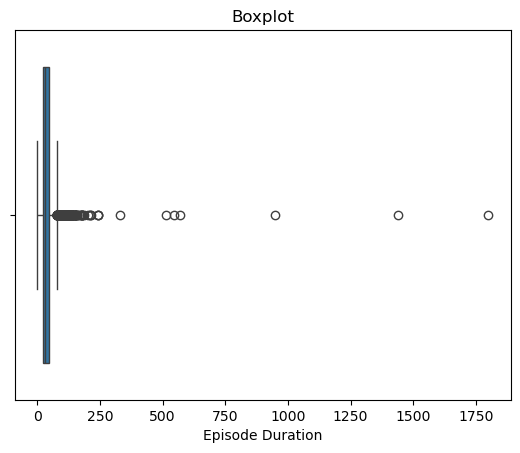

In [485]:
sns.boxplot(data = df, x="Episode Duration")
plt.title(f"Boxplot")

In [486]:
# Checking how many values will be removed if the outliers are removed
iqr = np.percentile(df["Episode Duration"],75) - np.percentile(df["Episode Duration"],25)
upper_limit = np.percentile(df["Episode Duration"],75) + 1.5*iqr
print(upper_limit)


79.5


In [487]:
df[df["Episode Duration"]> 80] # hay 318 series que duren más de 80 min

Title  \
0                                       gh dúo   
4                                  running man   
10             la casa de los famosos colombia   
12                          infinite challenge   
24                      the return of superman   
40                               american idol   
59                                 volle kanne   
63                          2 days and 1 night   
67                           masterchef greece   
73                              champs-elysées   
79                                 big brother   
124                                 home alone   
134                               secret story   
145                          my little old boy   
184                                m countdown   
190                                dalli dalli   
191                             we got married   
195                           men on a mission   
208                                fort boyard   
215    mystery music show: king of mask singer   
226                 aibou: tokyo detective duo   
230                             zone interdite   
236                            australian idol   
252                               dimension 20   
263                             polizeiruf 110   
269                 the fishermen and the city   
279                                 golden boy   
299                                        raw   
323                             hello saturday   
339                                      ri:se   
355                                  quotidien   
368                           midsomer murders   
389                              murders in...   
420                             cuarto milenio   
424                               back streets   
469                              back to field   
483                          çocuklar duymasın   
502                         scene of the crime   
507                                 yasak elma   
552                                    wwe nxt   
607                              kuruluş osman   
615                             boundless love   
624                                    live pd   
720                              morgenmagazin   
736                          temptation island   
770                                the manager   
800                           chef & my fridge   
857                                       gmtv   
870                      voetbal international   
886                   the valley of the wolves   
894                            abnormal summit   
951                                tna impact!   
986                                  snl korea   
1033                                daydreamer   
1075                              the bachelor   
1086                    the chinese restaurant   
1105                                 smtv live   
1132                             family outing   
1142                                      vera   
1144                              rischiatutto   
1152                                  stern tv   
1159                                avn awards   
1163                        masterchef türkiye   
1224                                     iumor   
1228             all elite wrestling: dynamite   
1264                             ndr talk show   
1353               mehmed: sultan of conquests   
1400                              keep running   
1429                                   vértigo   
1432                   new journey to the west   
1524                         masterchef méxico   
1535                                time story   
1577                            live & kicking   
1633                        ihlamurlar altinda   
1673                             home & family   
1697                                  sherlock   
1774                                mr. player   
1777                  agatha christie's marple   
1810                                    putous   
1828                    robinson ekspedit

In [488]:
# sustituyo los valores incorrectos

In [489]:
df.loc[df["Title"] == "the wonderful world of disney", "Episode Duration"]= 70 

In [490]:
df.loc[df["Title"] == "ray donovan", "Episode Duration"]= 50

# quiero ver cuales son las series que están mal porque tienen 0 min de duración

In [491]:
df[df["Episode Duration"] == 0] # hay 1296

Title  \
8                                            squid game   
15                                       volta por cima   
16                                        she's the one   
21                                          markus lanz   
25                                             brothers   
26                                      crazy about you   
29                                    law of the jungle   
30                                         binnelanders   
37                                            a fazenda   
46                                          chiquititas   
49                                    zdf-fernsehgarten   
55                  brave son of india: maharana pratap   
61                                           villa rosa   
65                                           suidooster   
66                                          yellowstone   
70                                  a caverna encantada   
84                                   die landarztpraxis   
86                                       de bondgenoten   
100                                              dexter   
101                                       critical role   
106                                          invincible   
107                                          la promesa   
108                                     game of thrones   
112                                       the mentalist   
113                                   vivement dimanche   
121                                                ncis   
125                                 la mujer de mi vida   
132                                        breaking bad   
133                                      come home love   
135                       las hijas de la señora garcia   
141                                             gg bond   
148                                             rt life   
159                                            survivor   
173                                       the blacklist   
176                                          paw patrol   
181                                            paradise   
182                                 kelders van geheime   
183                      ready steady cook south africa   
194                                           severance   
196             miraculous: tales of ladybug & cat noir   
199                                       astrid clover   
203                                           shameless   
214                                     hello counselor   
222                                         tenali rama   
242                                desperate housewives   
245                                dexter: original sin   
251                                                from   
253            yonimo kimyou na monogatari tokubetsuhen   
255                                         beast games   
256                                            the boys   
258                                       sakamoto days   
261                                           incognito   
265                                                lost   
268                                             pokémon   
270                                               x-man   
271                                          animaniacs   
272                               i love you, don't cry   
280                                     the good doctor   
282                                   anything for love   
290                                                silo   
293                                               bones   
294                                             columbo   
300                                       brazil avenue   
302                                      peaky blinders   
303                                        young hearts   
306                                    soonpoong clinic   
316                                              bravo!   
320                                   

In [492]:
episode_duration= {
    'dexter': 50, 'game of thrones':60, 'the mentalist':40, 'ncis':44,
       'breaking bad':50, 'survivor':60, 'the blacklist':45, 'paradise':55,
       'shameless':50, 'desperate housewives':42, 'lost':43, 'bones':43, 'columbo':78,
       's.w.a.t.':43, 'the walking dead':50, 'fargo':52, 'the flash':43,
       'the late show with stephen colbert':46,
       'csi: crime scene investigation':43, 'community':20, 'stranger things':56,
       'two and a half men':22, 'the sopranos':60, 'the office':30, 'blue bloods':45,
       'seinfeld':24, 'seal team':43, 'the orville':44, 'better call saul':45,
       'newsradio':23, 'futurama':22, 'outlander':60, 'the x-files':50,
       'ghost whisperer':45, 'curb your enthusiasm':30,
       'buffy the vampire slayer':45, 'saturday night live':65,
       "rupaul's drag race":50, 'star trek: discovery':60, 'chernobyl':65,
       'mad men':47, 'jag':44, "tom clancy's jack ryan":60, 'westworld':60,
       "it's always sunny in philadelphia":20, 'web therapy':25,
       'star wars rebels':22, 'medium':45, 'arrested development':22, 'matlock':42,
       'succession':60, 'love, death & robots':15, 'orange is the new black':60,
       'mr. robot':60, 'narcos':50, 'the agency':50,
       'last week tonight with john oliver':32, 'in treatment':25,
       'the equalizer':44, 'what we do in the shadows':30, 'ozark':60, 'entourage':28,
       'days of our lives':60, 'shooter':41, 'little house on the prairie':60,
       'family ties':25, 'the umbrella academy':50, '13 reasons why':50,
       'house of cards':50, 'the marvelous mrs. maisel':57, 'justified':42,
       'deadliest catch':45, 'ballers':30, 'atlanta':30, 'honest trailers':7,
       'my name is earl':21, 'the leftovers':55, 'mindhunter':50, 'six feet under':55,
       'empire':42, 'bates motel':45, 'the six million dollar man':55,
       'naked and afraid':43, 'amazing stories':30, 'the ranch':30,
       'carpool karaoke: the series':18,
       'terminator: the sarah connor chronicles':43, 'the killing':50,
       'the life and legend of wyatt earp':30, 'life on mars':52, 'sense8':60,
       'battlestar galactica':44, 'masters of horror':60, 'the conners':22,
       'epic rap battles of history':5, 'russian doll':25,
       'naked and afraid xl':42, 'glow':35,'yellowstone':60, 'critical role':27, 'invincible':45, 'rt life':5,
       'paw patrol':22, 'severance':45, 'dexter: original sin':50,
       'from':50, 'beast games':50, 'the boys':60, 'animaniacs':23, 'the good doctor':42,
       'silo':50, 'high potential':43, 'young sheldon':20, 'the night agent':50,
       'teen wolf':43, 'hey qween!':38, 'euphoria':55, 'fear the walking dead':45,
       'lioness':45, 'house of the dragon':60, 'reacher':42,
       'the lord of the rings: the rings of power':60, 'arrow':43, 'snowfall':50,
       'arcane':45, 'xo, kitty':30, 'unhhhh':10, 'tulsa king':40, 'ted lasso':35,
       'the witcher':50, 'the jennifer hudson show':60, 'american primeval':50,
       'gossip girl':42, 'the 7d':30, 'the recruit':55, 'bridgerton':60, 'rwby chibi':11,
       'dune: prophecy':60, 'you':50, 'landman':55, 'what if...?':35, 'virgin river':45,
       'the white lotus':55, 'halo':60, '9-1-1: lone star':43,
       'mayor of kingstown':47, 'scorpion':40, 'wednesday':50,
       'white collar':42,'tracker':50, 'night gallery':50,
       'star wars: skeleton crew':40, 'see':54, 'the last of us':55, 'the penguin':60,
       'sex/life':45, 'lego ninjago: dragons rising':23, 'designated survivor':42,
       'common side effects':22, 'shōgun':60, 'hey! (ew)':30, 'tribunal justice':60,
       'mickey mouse clubhouse':23, 'vikings: valhalla':50,
       'the walking dead: daryl dixon':60, '1923':58, 'carnival row':55,
       'beverly hills, 90210':45, 'snowpiercer':45, 'castlevania':25,
       'the mandalorian':40, 'teacup':30, 'titans':45, 'dickinson':30,
       'the real housewives of beverly hills':43, 'the pitt':50,
       'narcos: mexico':60, 'mythic quest':30,
       'the walking dead: the ones who live':45, 'selling sunset':30, 'on call':30,
       'la fan':45, 'the summer i turned pretty':43, 'servant':30, 'wwe 24':30,
       'cupcake wars':42, 'battlefield friends':4, 'elsbeth':43,
       'the kardashians':40, 'karamo show':60, '1883':50, 'emily in paris':30,
       'schmigadoon!':30, 'the replacements':58, 'for all mankind':60,
       'loki':45, 'the wheel of time':60, 'obliterated':50,
       'agatha all along':40, 'the lincoln lawyer':50,
       'fire country':44, 'avatar the last airbender':60,
       'fallout':60, 'will trent':44, 'doc mcstuffins':24, 'creature commandos':23,
       'masters of the air':57, 'norman picklestripes':21, 'hawkeye':40,
       'the falcon and the winter soldier':50, 'highlander: the series':48,
       'the bold and the beautiful':22, 'mayfair witches':60, 'foundation':60,
       'looney tunes cartoons':10, 'invasion':55, 'school spirits':45,
       'peacemaker':43, 'cruel intentions':42, 'fresh off the boat':21,
       'little america':30, 'monsters':50,
       'chilling adventures of sabrina':57, 'shrinking':35, 'johnny bravo':22,
       'the morning show':55, 'wandavision':60, 'ikaw lamang':40,
       'castlevania: nocturne':27, 'only murders in the building':30,
       'the bear':37, 'rainbow high':10, "america's funniest home videos":38,
       'star wars: the bad batch':40, 'walker, texas ranger':43,
       "georgie & mandy's first marriage":20, 'star trek: picard':50,
       'goosebumps':22, 'sweet tooth':45, 'ncis: origins':43, 'cross':55,
       'raised by wolves':50, 'abbott elementary':22, 'one piece':23,
       'star trek: lower decks':30,
       'vindication':30, 'interior chinatown':40, 'the walking dead: dead city':44,
       'tell me lies':49, 'the sandman':50, 'the young turks':54, 'the dead zone':41,
       'superbuns':8, 'godfather of harlem':55, 'secret level':15, 'guidance':27,
       '3 body problem':50, 'disenchantment':30, 'the haunting of hill house':55,
       'my life with the walter boys':45, 'the madness':48, 'love, victor':24,
       'party down':30, 'the chi':60, 'el conde: amor y honor':60,
       "the queen's gambit":50, 'grown-ish':22, 'halloween wars':42,
        'knuckles':30, 'grotesquerie':45, "x-men '97":32,
       'presumed innocent':43, 'dark matter':43, 'roadkill':20,
       'american crime story':42, 'pawn stars':23, 'the irrational':42,
       'rooster teeth animated adventures':15,
       'star wars: andor':41, 'percy jackson and the olympians':40,
       'unusual suspects':42, 'dahmer - monster: the jeffrey dahmer story':50,
       'bossy bear':22, 'elena of avalor':25, 'the great':50, 'kingdom':50,
       'earth abides':52, 'say nothing':44, 'the rachel maddow show':60,
       'stargate origins':10, 'upload':32, 'a man on the inside':30,
       'she-hulk: attorney at law':35, 'those about to die':44, 'walker':42,
       'star trek: strange new worlds':55, 'adventure time: fionna & cake':27,
       'shape island':22, 'crown lake':30, "let's play minecraft":23,
       'monarch: legacy of monsters':60, 'the librarians':43,
       'dateline: unforgettable':85, 'bel-air':51,
       'bbq brawl':30, 'beauty in black':48, 'tabletop':32,
       'sausage party: foodtopia':25, 'the acolyte':40,
       'the shannara chronicles':42, 'the gilded age':54, 'pachinko':52,
       'black bird':58, 'the idol':50, 'the old man':55,
       'voltron: legendary defender':24, 'interview with the vampire':50,
       'ripley':55, 'pantheon':41, 'the flight attendant':45, 'world war two':45,
       'bookie':23, '61st street':45, 'nobody wants this':25, 'pupstruction':11,
       'sonic prime':26, 'poker face':58,
       "guillermo del toro's cabinet of curiosities":60, 'heels':58, 'the ark':43,
       'the continental: from the world of john wick':85, 'gayle':5,
       'sweat equity':20, 'tokyo vice':57, 'watchmen':59, 'ted':40,
       'expedition bigfoot':42, 'monsters at work':25, 'mr. corman':30,
       'the spiderwick chronicles':45, 'the terminal list':55,
       'smosh':5, 'american horror stories':43, 'yellowstone: one-fifty':40,
       'beef':35, 'maid':50, 'the angry video game nerd':30, 'joe pickett':48,
       'outer range':50, 'tumble leaf':22, 'unbelievable':50,
       'the mosquito coast':50, 'new york undercover':60,
       'rubble & crew':18, 'paradise run':23, 'and just like that…':40,
       'love is blind':55, 'acapulco':30, 'blue eye samurai':45, 'firefly lane':50,
       'life in pieces':22, 'human resources':28, "squid game":60
}

In [493]:
# Iteramos sobre las filas donde "Episode Duration" es 0
for index, row in df[df["Episode Duration"] == 0].iterrows():
    title = row["Title"]
    # Comprobar si el título está en el diccionario
    if title in episode_duration:
        # Usar loc[] para cambiar el valor en la fila correspondiente
        df.loc[df["Title"] == title, "Episode Duration"] = episode_duration[title]

In [494]:
# convierto la duración a int
df["Episode Duration"] = df["Episode Duration"].astype(int)

Text(0.5, 1.0, 'Histograma')

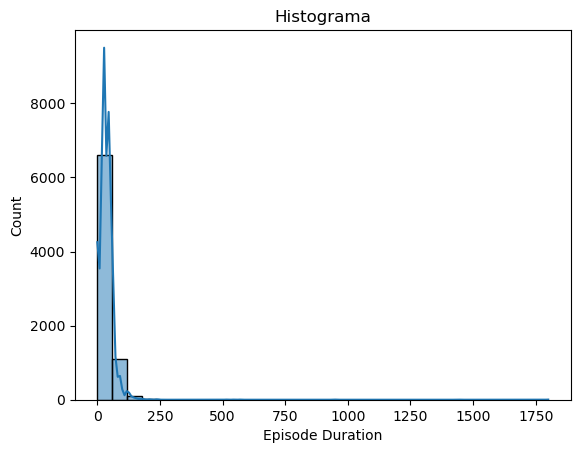

In [495]:
sns.histplot(data = df, x= "Episode Duration", bins = 30, kde = True)
plt.title(f"Histograma")

Text(0.5, 1.0, 'Boxplot')

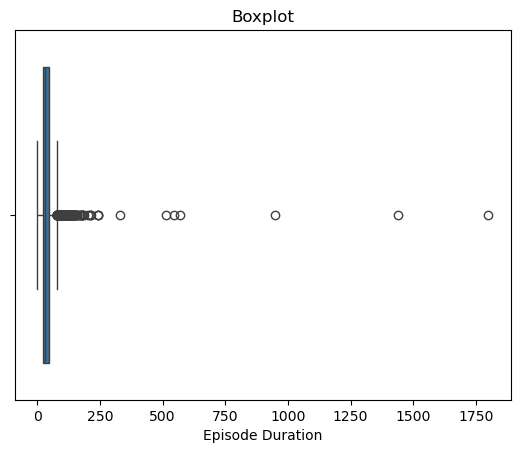

In [496]:
sns.boxplot(data = df, x="Episode Duration")
plt.title(f"Boxplot")

In [497]:
df.loc[df["Episode Duration"]>500] # los eliminamos


Title                                           Synopsis  \
3890     polskie drogi                                                NaN   
4272     al zeer salem  A historical series embodying the character of...   
5453             solos                                                NaN   
6307              mani  Sky's parents hire an unconventional nanny nam...   
7893  toward the terra  In the future, mankind's seemingly utopian soc...   
9544     the whirlwind  A whirlwind power clash between the prime mini...   

                           Genero  Rating  Popularity  Vote Count  \
3890        War & Politics, Drama   7.000    4.532245    1.386294   
4272                        Drama   8.000    4.460168    1.386294   
5453                Reality, Talk   5.500    4.287840    0.693147   
6307                       Comedy   7.600    4.170132    2.079442   
7893  Animation, Sci-Fi & Fantasy   7.500    3.981101    2.079442   
9544        Drama, War & Politics   7.273    3.816195    3.091042   

     Original Language Origin Country  In production            Status  \
3890                pl             PL          False             Ended   
4272                ar             SY          False             Ended   
5453                es             ES           True  Returning Series   
6307                en             US           True  Returning Series   
7893                ja             JP          False             Ended   
9544                ko             KR          False             Ended   

      Number of Season  Number of Episodes  Episode Duration  \
3890          1.000000            2.397895               949   
4272          1.000000            3.688879              1800   
5453          2.000000            5.081404              1440   
6307          2.828427            4.248495               515   
7893          1.000000            3.178054               570   
9544          1.000000            2.484907               545   

                       Where to Watch     Reviews  release_year  
3890           No platforms available  No reviews        1977.0  
4272                       Shahid VIP  No reviews        2000.0  
5453           No platforms available  No reviews        2020.0  
6307           No platforms available  No reviews        2017.0  
7893           No platforms available  No reviews        2007.0  
9544  Netflix basic with Ads, Netflix  No reviews        2024.0

In [498]:
df = df.drop(df[df["Title"].isin(["polskie drogi", "al zeer salem", "solos", "mani", "toward the terra", "the whirlwind"])].index)

Text(0.5, 1.0, 'Boxplot')

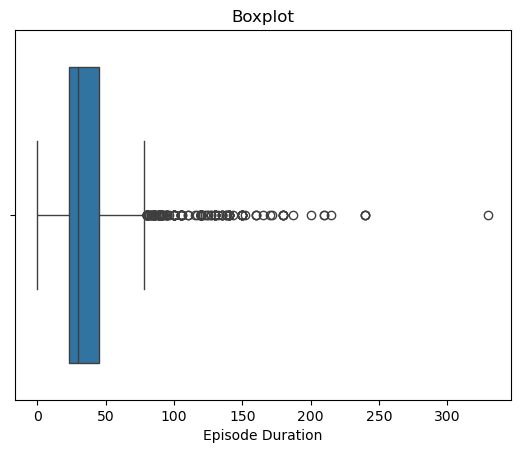

In [499]:
sns.boxplot(data = df, x="Episode Duration")
plt.title(f"Boxplot")

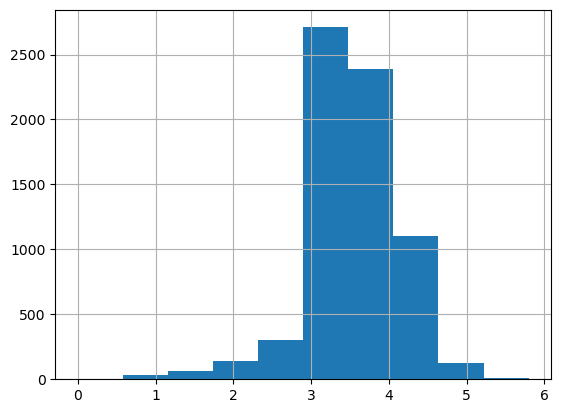

In [500]:
# Using the functions to check the distribution of transformed data
pd.Series(map(log_transfom_clean_, df["Episode Duration"])).hist()
plt.show()

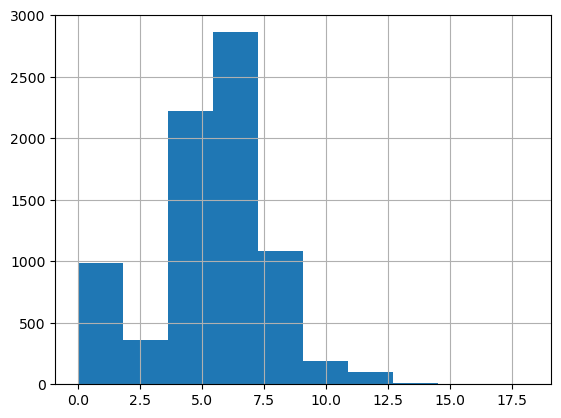

In [501]:
pd.Series(map(sqrt_transfom_clean_, df["Episode Duration"])).hist()
plt.show()

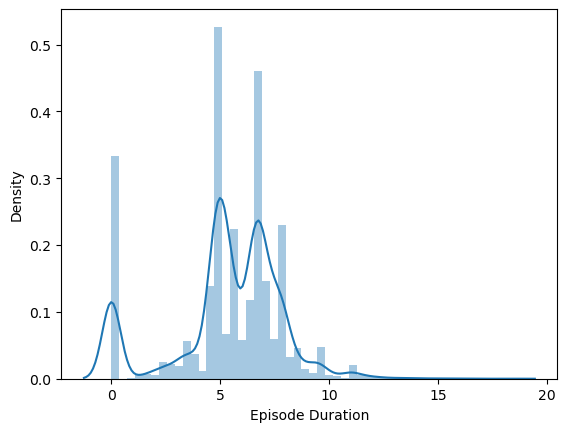

In [502]:
# Use sqrt transformation to replace the values of the column now
df["Episode Duration"] = list(map(sqrt_transfom_clean_, df["Episode Duration"]))
sns.distplot(df["Episode Duration"])
plt.show()

### RELEASE YEAR

Text(0.5, 1.0, 'Histograma')

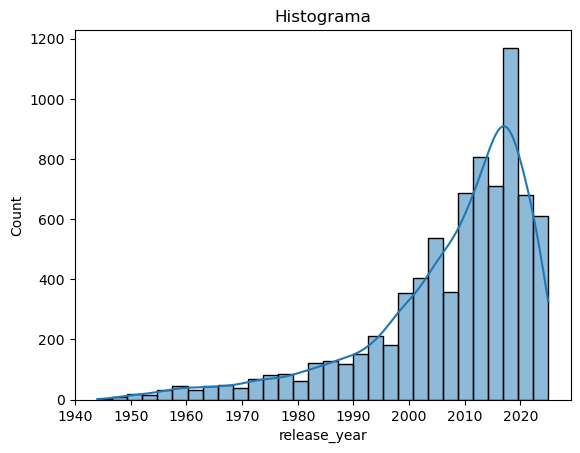

In [503]:
sns.histplot(data = df, x= "release_year", bins = 30, kde = True)
plt.title(f"Histograma")

Text(0.5, 1.0, 'Boxplot')

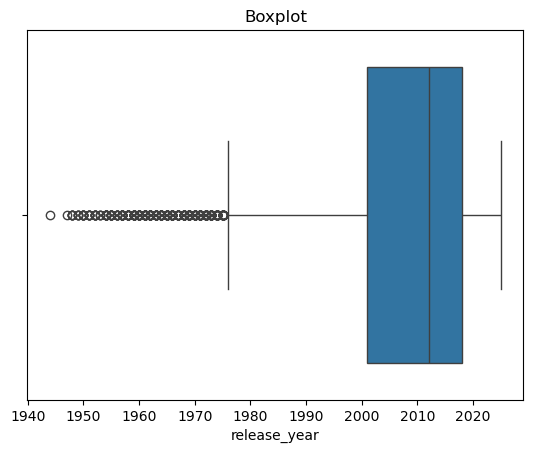

In [504]:
sns.boxplot(data = df, x="release_year")
plt.title(f"Boxplot")

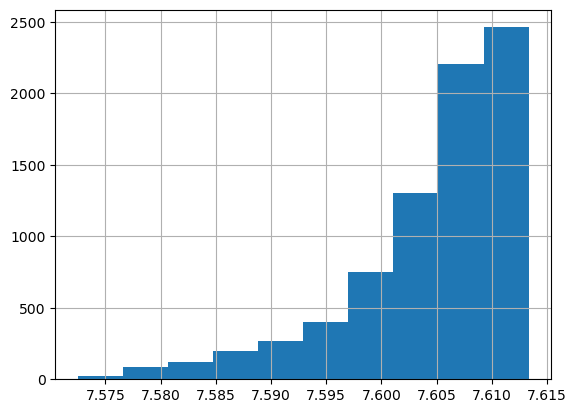

In [505]:
# Using the functions to check the distribution of transformed data
pd.Series(map(log_transfom_clean_, df["release_year"])).hist()
plt.show()

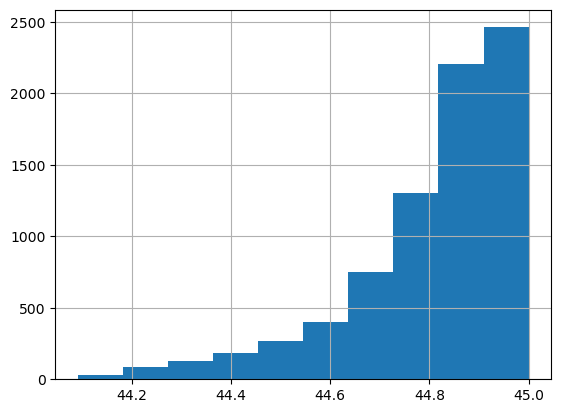

In [506]:
pd.Series(map(sqrt_transfom_clean_, df["release_year"])).hist()
plt.show()

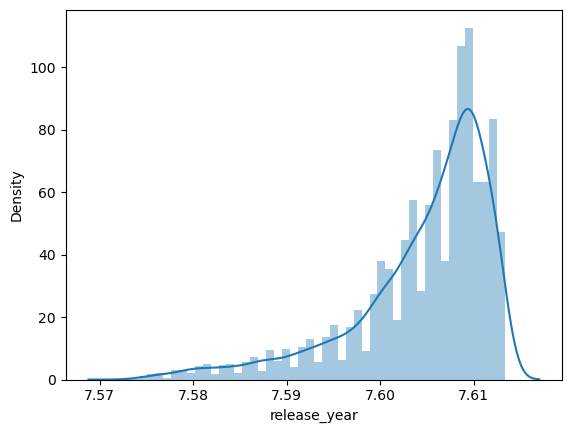

In [507]:
# Use log transformation to replace the values of the column now
df["release_year"] = list(map(log_transfom_clean_, df["release_year"]))
sns.distplot(df["release_year"])
plt.show()

In [508]:
df.describe()

Rating   Popularity   Vote Count  Number of Season  \
count  7822.000000  7822.000000  7822.000000       7822.000000   
mean      6.979302     4.573104     2.818598          1.844814   
std       1.592987     0.668274     2.214787          1.157083   
min       0.500000     3.803502     0.000000          1.000000   
25%       6.200000     4.065413     1.098612          1.000000   
50%       7.258500     4.392293     2.302585          1.414214   
75%       8.000000     4.904035     4.418841          2.236068   
max      10.000000     7.916605    10.108874         14.071247   

       Number of Episodes  Episode Duration  release_year  
count         7822.000000       7822.000000   7810.000000  
mean             4.300189          5.357849      7.604569  
std              1.187363          2.527775      0.007426  
min              0.693147          0.000000      7.572503  
25%              3.526361          4.795832      7.601402  
50%              4.158883          5.477226      7.606885  
75%              5.010635          6.708204      7.609862  
max              9.125980         18.165902      7.613325

In [509]:
num = ["Rating", "Popularity", "Vote Count", "Number of Season", "Number of Episodes", "Episode Duration","release_year"]


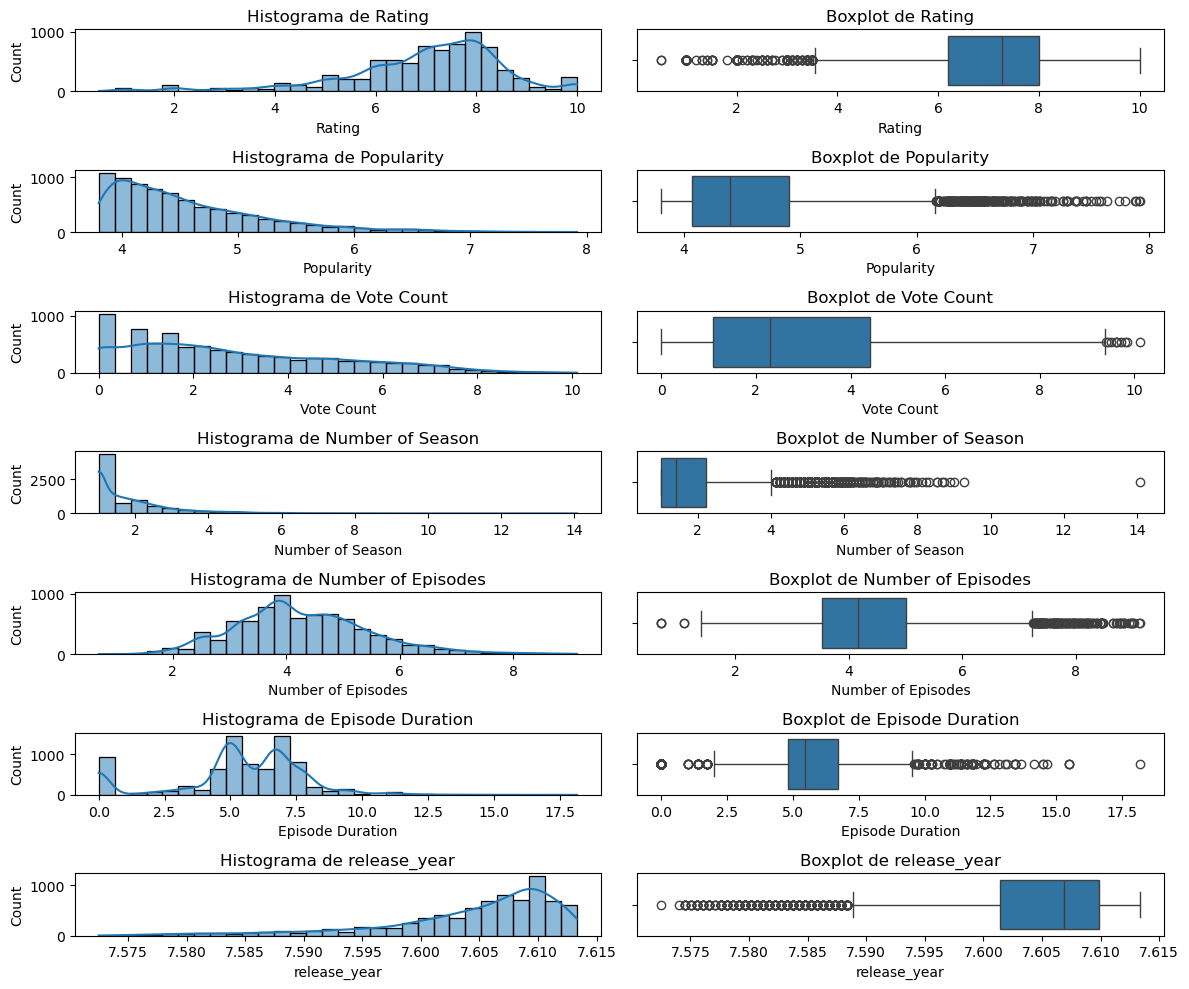

In [510]:
plt.figure(figsize=(12, 10))
for i, column in enumerate(num, 1):
    plt.subplot(len(num), 2, i*2-1)
    sns.histplot(df[column], bins = 30, kde = True)
    plt.title(f"Histograma de {column}")

    plt.subplot(len(num), 2, i*2)
    sns.boxplot(x=df[column])
    plt.title(f"Boxplot de {column}")

plt.tight_layout()
plt.show()

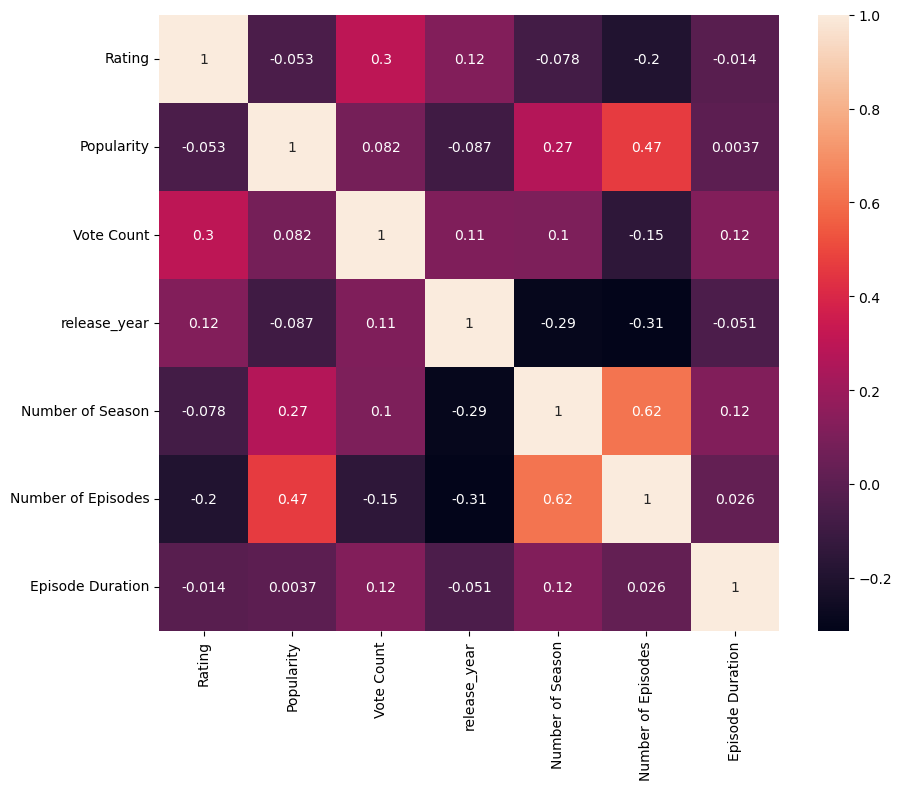

In [511]:
# miramos si hay multicolinealidad entre variables númericas
data_corr = df[['Popularity', 'Vote Count', 'release_year', 'Number of Season', 'Number of Episodes', 'Episode Duration']]
corr_matrix=data_corr.corr(method='pearson')
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()


In [524]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6719 entries, 1 to 9694
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Title               6719 non-null   object 
 1   Synopsis            6719 non-null   object 
 2   Genero              6719 non-null   object 
 3   Rating              6719 non-null   float64
 4   Popularity          6719 non-null   float64
 5   Vote Count          6719 non-null   float64
 6   Original Language   6719 non-null   object 
 7   Origin Country      6719 non-null   object 
 8   In production       6719 non-null   bool   
 9   Status              6719 non-null   object 
 10  Number of Season    6719 non-null   float64
 11  Number of Episodes  6719 non-null   float64
 12  Episode Duration    6719 non-null   float64
 13  Where to Watch      6719 non-null   object 
 14  Reviews             6719 non-null   object 
 15  release_year        6719 non-null   float64
dtypes: bool(1),

In [ ]:
df.dropna(subset=["Synopsis", "Genero", "release_year"], inplace=True)

In [527]:
numericals = df[["Popularity", "Vote Count", "release_year", "Number of Season", "Number of Episodes", "Episode Duration"]]

### MIRAMOS VIF

In [528]:
# para cerciorarnos usamos VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Features"]= numericals.columns
vif_data["VIF"] = [variance_inflation_factor(numericals.values, i) for i in range(numericals.shape[1])]

print("Caracteristicas con VIF alot: \n", vif_data[vif_data["VIF"]>10]) # 10 es el umbral 

Caracteristicas con VIF alot: 
              Features        VIF
0          Popularity  64.315162
2        release_year  55.610478
4  Number of Episodes  29.994540


In [529]:
def calcular_vif(data):
    """Calcula el VIF para cada variable en el DataFrame."""
    vif_data = pd.DataFrame()
    vif_data["Variable"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_data

def eliminar_variables_vif(data, umbral=10):
    """
    Elimina las variables con el mayor VIF de forma iterativa 
    hasta que todas las variables tengan un VIF inferior al umbral.
    """
    iteracion = 1
    while True:
        print(f"\n--- Iteración {iteracion} ---")
        

        vif_data = calcular_vif(data)
        print(vif_data)
        
        max_vif = vif_data["VIF"].max()
        if max_vif < umbral:
            print("\n✅ Todas las variables tienen VIF menor que", umbral)
            break
        

        variable_a_eliminar = vif_data.loc[vif_data['VIF'].idxmax(), 'Variable']
        print(f"\n⚠️ Se eliminará la variable con mayor VIF: {variable_a_eliminar} (VIF={max_vif})")
        
        data = data.drop(columns=[variable_a_eliminar])
        
        iteracion += 1
        
    print("\n📊 Proceso finalizado. Variables restantes:")
    print(data.columns)
    return data, vif_data

numericals_final, vif_final = eliminar_variables_vif(numericals, umbral=10)


--- Iteración 1 ---
             Variable        VIF
0          Popularity  64.315162
1          Vote Count   3.444658
2        release_year  55.610478
3    Number of Season   6.488301
4  Number of Episodes  29.994540
5    Episode Duration   6.577070

⚠️ Se eliminará la variable con mayor VIF: Popularity (VIF=64.31516171338835)

--- Iteración 2 ---
             Variable        VIF
0          Vote Count   3.326321
1        release_year  23.843718
2    Number of Season   6.446047
3  Number of Episodes  24.291844
4    Episode Duration   6.563634

⚠️ Se eliminará la variable con mayor VIF: Number of Episodes (VIF=24.291843560329408)

--- Iteración 3 ---
           Variable       VIF
0        Vote Count  3.091974
1      release_year  9.148920
2  Number of Season  3.677235
3  Episode Duration  6.550898

✅ Todas las variables tienen VIF menor que 10

📊 Proceso finalizado. Variables restantes:
Index(['Vote Count', 'release_year', 'Number of Season', 'Episode Duration'], dtype='object')


In [ ]:
# según el VIF, variance inflation factor
# las variables popularity y number of episodes están muy correlacionadas con otras, generan ruido

### RECURSIVE FEATURE ELIMINATION (RFE)

In [562]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

model= LinearRegression()

selector= RFE(estimator=model, n_features_to_select= 5)

numericals_selected = selector.fit_transform(numericals, df["Rating"])

selected_features = numericals.columns[selector.get_support()]

print("Caracteristicas seleccionadas:", selected_features.tolist())

Caracteristicas seleccionadas: ['Vote Count', 'release_year', 'Number of Season', 'Number of Episodes', 'Episode Duration']


### PCA

Varianza explicada por los primeros componentes:
Componente 1: 0.4314 (Acumulada: 0.4314)
Componente 2: 0.3421 (Acumulada: 0.7735)
Componente 3: 0.1677 (Acumulada: 0.9412)
Componente 4: 0.0385 (Acumulada: 0.9798)
Componente 5: 0.0202 (Acumulada: 1.0000)
Componente 6: 0.0000 (Acumulada: 1.0000)


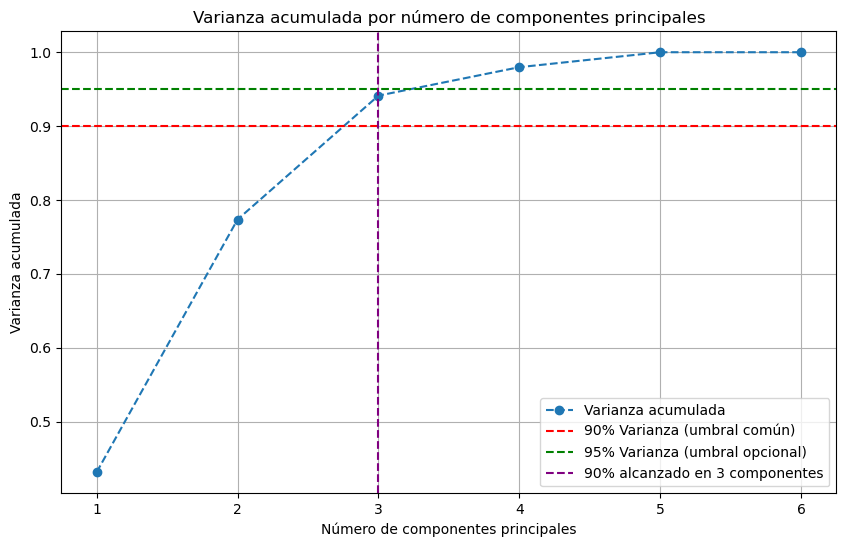

In [563]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Configurar y ajustar PCA a las variables numéricas
pca = PCA()
pca.fit(numericals)

# Calcular varianza explicada y acumulada
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Mostrar los primeros 10 componentes (o ajustar según el caso)
n_components_to_display = min(20, len(cumulative_variance))  # Mostrar hasta 20 o el total de componentes
print("Varianza explicada por los primeros componentes:")
for i in range(n_components_to_display):
    print(f"Componente {i+1}: {explained_variance[i]:.4f} (Acumulada: {cumulative_variance[i]:.4f})")

# Visualizar la varianza explicada acumulada
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', label="Varianza acumulada")
plt.title("Varianza acumulada por número de componentes principales")
plt.xlabel("Número de componentes principales")
plt.ylabel("Varianza acumulada")
plt.axhline(y=0.9, color='r', linestyle='--', label="90% Varianza (umbral común)")
plt.axhline(y=0.95, color='g', linestyle='--', label="95% Varianza (umbral opcional)")
plt.grid()
plt.legend()

# Asegurarse de resaltar el "codo" si se encuentra en una región más alta
# Encontrar el índice del codo (donde la varianza acumulada alcanza el 90%)
num_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
plt.axvline(x=num_components_90, color='purple', linestyle='--', label=f"90% alcanzado en {num_components_90} componentes")

plt.legend()
plt.show()


## VARIABLES CATEGORICAS

### 1. GENEROS

In [533]:
df["Genero"] # tengo los generos en una string juntos

1                                                   Drama
3                                                    News
4                                         Comedy, Reality
5                                             Drama, Soap
6       Comedy, Action & Adventure, Kids, Animation, F...
7                                                   Drama
8                      Action & Adventure, Mystery, Drama
11                                                   Soap
12                                        Reality, Comedy
13                                                Reality
14                                          Drama, Family
16                                            Soap, Drama
17      Animation, Action & Adventure, Comedy, Family,...
18                                                   Soap
19                                          Comedy, Drama
20      Comedy, Drama, Family, Action & Adventure, Kid...
21                                                   Talk
22            

In [534]:
# quiero sacar los generos unicos, para ello tengo que hacer split
# cojo cada genero que está después de la coma
df["Genero"] = df["Genero"].apply(lambda x: x.split(', ') if isinstance(x, str) else x) 
# antes del explode necesito hacer un split porque los generos son strings
# con el split cada genero individual es un string
df["Genero"] # ahora los generos son listas de strings ["Talk", "Comedy", "News"]

1                                                 [Drama]
3                                                  [News]
4                                       [Comedy, Reality]
5                                           [Drama, Soap]
6       [Comedy, Action & Adventure, Kids, Animation, ...
7                                                 [Drama]
8                    [Action & Adventure, Mystery, Drama]
11                                                 [Soap]
12                                      [Reality, Comedy]
13                                              [Reality]
14                                        [Drama, Family]
16                                          [Soap, Drama]
17      [Animation, Action & Adventure, Comedy, Family...
18                                                 [Soap]
19                                        [Comedy, Drama]
20      [Comedy, Drama, Family, Action & Adventure, Ki...
21                                                 [Talk]
22            

In [535]:
# divido los generos combinados en filas separadas con el explode
# quiero conseguir los generos únicos
generos_exploded = df.explode("Genero")
generos_exploded["Genero"]


1                    Drama
3                     News
4                   Comedy
4                  Reality
5                    Drama
5                     Soap
6                   Comedy
6       Action & Adventure
6                     Kids
6                Animation
6                   Family
7                    Drama
8       Action & Adventure
8                  Mystery
8                    Drama
11                    Soap
12                 Reality
12                  Comedy
13                 Reality
14                   Drama
14                  Family
16                    Soap
16                   Drama
17               Animation
17      Action & Adventure
17                  Comedy
17                  Family
17                    Kids
18                    Soap
19                  Comedy
19                   Drama
20                  Comedy
20                   Drama
20                  Family
20      Action & Adventure
20                    Kids
20                   Crime
2

In [536]:
# cuento los generos unicos
generos_count = generos_exploded["Genero"].value_counts(dropna = False)
generos_count.columns = ['Genero', 'Total']
generos_count

Genero
Drama                 3433
Comedy                2457
Animation             1881
Action & Adventure    1473
Sci-Fi & Fantasy      1341
Family                 803
Crime                  686
Mystery                570
Kids                   550
Reality                424
Soap                   387
Talk                   219
Documentary            165
War & Politics         147
News                    73
Western                 51
Desconocido             42
Name: count, dtype: int64

In [539]:
# agrupamos los generos en 7
agrupacion_generos = {
    "Crime": "Drama",
    "Sci-Fi & Fantasy": "Action & Adventure",
    "Family": "Kids",  
    "Mystery": "Action & Adventure", 
    "Animation": "Kids",
    "Reality": "Entertainment",
    "Talk": "Entertainment",
    "Western": "Documentary",
    "Soap": "Drama",
    "War & Politics": "Documentary",
    "News":"Entertainment",
    "Desconocido": "Entertainment"}

In [541]:
# Función para mapear los géneros 
def map_generos(lista_generos, agrupacion_generos):
    
    # Aplicamos el mapeo de cada género individualmente
    genero_mapped = []
    for genero in lista_generos:
        if genero in agrupacion_generos:
            genero_mapped.append(agrupacion_generos[genero])
        else:
            genero_mapped.append(genero)

    return list(set(genero_mapped))

# Convertir los géneros de una lista a su categoría agrupada
df["Genero_agrup"] = df["Genero"].apply(lambda x: map_generos(x, agrupacion_generos))


In [542]:
df["Genero_agrup"]

1                                                 [Drama]
3                                         [Entertainment]
4                                 [Entertainment, Comedy]
5                                                 [Drama]
6                      [Action & Adventure, Kids, Comedy]
7                                                 [Drama]
8                             [Action & Adventure, Drama]
11                                                [Drama]
12                                [Comedy, Entertainment]
13                                        [Entertainment]
14                                          [Kids, Drama]
16                                                [Drama]
17                     [Action & Adventure, Kids, Comedy]
18                                                [Drama]
19                                        [Comedy, Drama]
20              [Action & Adventure, Kids, Comedy, Drama]
21                                        [Entertainment]
22            

In [341]:
# ahora quiero crear 6 columnas adicionales booleanas (una para cada genero) 
# que sean 1 si esa serie tiene ese genero y 0 si la serie no es de ese genero

In [543]:
# Listado de géneros posibles
genres = ["Drama", "Comedy", "Action & Adventure", "Kids", "Entertainment", "Documentary"]

# Crear las columnas de género con 1 si el género está presente, 0 si no
for genre in genres:
    df[genre] = df["Genero_agrup"].apply(lambda x: 1 if genre in x else 0)

In [544]:
df.drop(columns=["Genero"], inplace=True)


In [546]:
df_genero_dummies = df[["Drama", "Comedy", "Action & Adventure", "Kids","Entertainment", "Documentary" ]]

### 2. STATUS


In [547]:
df["Status"].value_counts(dropna=False)

Status
Ended               4904
Returning Series    1499
Canceled             316
Name: count, dtype: int64

In [ ]:
# random forest es un modelo muy potente para sacar la feature importance (se puede utilizar para regresión linear también)
# transformar modelos que te retornan valores númericos a categoricos
# Sigmoid: función

In [548]:
df_status_dummies = pd.get_dummies(df["Status"], prefix="Status", drop_first=True)


### 3. SENTIMENT LABEL

In [ ]:
## quiero añadir 3 columnas que me indique el sentiment label basado en las reseñas o si no las hay en la sinopsis

In [549]:
import re
import nltk
nltk.download('punkt')  # Necesario para la tokenización
from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords # stopwords, palabras vacías
nltk.download('stopwords')

import spacy # lematización

nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package punkt to /Users/caterina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/caterina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/caterina/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [550]:
# Limpiar el texto (reseñas de moemnto)
def clean_text(text):
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar caracteres no alfabéticos (números y puntuación)
    text = re.sub(r'http\S+', '', text)  # Eliminar URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Eliminar caracteres no alfabéticos (números, símbolos)
    text = text.strip()  # Eliminar espacios extra
    return text

df["cleaned_sinpsis"] = df["Synopsis"].apply(clean_text)

In [552]:
# aplicamos tokenización
# dividimos le texto en palabras individuales o tokens
df['tokens'] = df['cleaned_sinpsis'].apply(word_tokenize)

In [553]:
# eliminamos las palabras "vacías", que no aportan significado
# Crear un conjunto de stopwords en español
stop_words = set(stopwords.words('english'))

# Eliminar stopwords de cada reseña
df['tokens_clean'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

In [554]:
sia = SentimentIntensityAnalyzer()

# Función para obtener el sentimiento del texto
def get_sentiment(text):
    sentiment_score = sia.polarity_scores(text)  # Da un diccionario con scores de sentimiento
    return sentiment_score["compound"]  # 'compound' es una puntuación agregada

# Función para obtener la etiqueta de sentimiento
def get_sentiment_label(score):
    if score > 0.05:
        return "positive"
    elif score < -0.05:
        return "negative"
    else:
        return "neutral"
    
# Función que determina si usar la reseña o la sinopsis para el análisis
def apply_sentiment(row):

    sentiment_score = get_sentiment(row["Synopsis"])
    
    # Obtener el label de sentimiento
    sentiment_label = get_sentiment_label(sentiment_score)
    
    return pd.Series([sentiment_score, sentiment_label])

In [555]:
# Aplicamos el análisis de sentimiento a cada fila
df[["Sentiment_Score", "Sentiment_Label"]] = df.apply(apply_sentiment, axis=1)


In [556]:
df_sentiment_dummies = pd.get_dummies(df["Sentiment_Label"], prefix="Sentiment", drop_first=True)


### 4. In Production

In [557]:
df_production_dummies = pd.get_dummies(df["In production"], prefix="in_production", drop_first=True)


In [559]:
categoricals= pd.concat([df_genero_dummies, df_sentiment_dummies, df_production_dummies], axis=1)
categoricals.head(20)

Drama  Comedy  Action & Adventure  Kids  Entertainment  Documentary  \
1       1       0                   0     0              0            0   
3       0       0                   0     0              1            0   
4       0       1                   0     0              1            0   
5       1       0                   0     0              0            0   
6       0       1                   1     1              0            0   
7       1       0                   0     0              0            0   
8       1       0                   1     0              0            0   
11      1       0                   0     0              0            0   
12      0       1                   0     0              1            0   
13      0       0                   0     0              1            0   
14      1       0                   0     1              0            0   
16      1       0                   0     0              0            0   
17      0       1                   1     1              0            0   
18      1       0                   0     0              0            0   
19      1       1                   0     0              0            0   
20      1       1                   1     1              0            0   
21      0       0                   0     0              1            0   
22      1       0                   0     0              0            0   
24      0       0                   0     0              1            0   
25      1       0                   1     0              0            0   

    Sentiment_neutral  Sentiment_positive  in_production_True  
1               False                True                True  
3               False                True                True  
4               False                True                True  
5                True               False               False  
6               False                True                True  
7                True               False                True  
8               False                True                True  
11              False                True                True  
12              False               False               False  
13              False                True                True  
14              False               False                True  
16              False               False                True  
17              False               False               False  
18               True               False                True  
19              False                True                True  
20              False                True                True  
21              False                True                True  
22              False                True               False  
24              False                True                True  
25              False                True               False

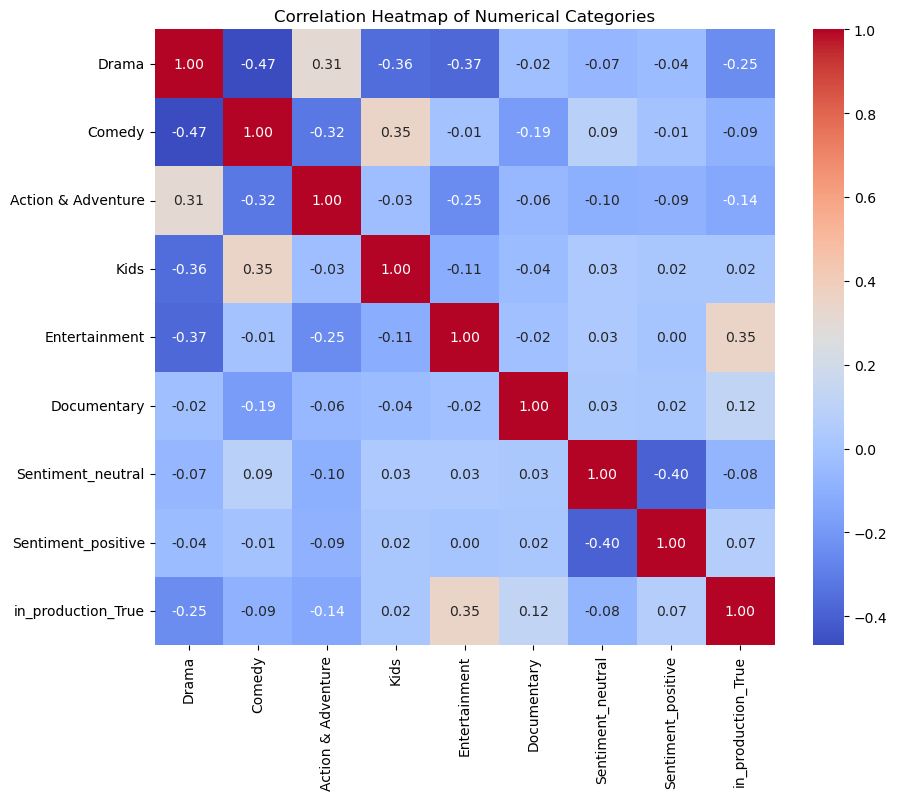

In [554]:
correlation_matrix = categoricals.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Categories')
plt.show()

In [567]:
from sklearn.feature_selection import chi2_contingency

# encodign
contingency_table = pd.crosstab(categoricals, df["Rating"])
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Imprime el p-value
print(f"P-value del Test Chi-cuadrado: {p}")

# chi2 alto y p valor bajo: las variables categoricas están relacionadas con la Y

ImportError: cannot import name 'chi2_contingency' from 'sklearn.feature_selection' (/opt/anaconda3/envs/original/lib/python3.12/site-packages/sklearn/feature_selection/__init__.py)

In [585]:
df_modelo = pd.get_dummies(df, columns=["Sentiment_Label", "In production"], drop_first=True)

In [587]:
df_modelo.drop(columns = ["Title", "Synopsis", "Original Language", "Origin Country", "Status", "Where to Watch", "Reviews", "Genero_agrup", "cleaned_sinpsis", "tokens", "tokens_clean", "Sentiment_Score"], inplace=True)

In [588]:
df_modelo.sample()

Rating  Popularity  Vote Count  Number of Season  Number of Episodes  \
6173     8.0    4.188093    4.962845               1.0            3.912023   

      Episode Duration  release_year  Drama  Comedy  Action & Adventure  Kids  \
6173          4.795832      7.601902      0       0                   1     1   

      Entertainment  Documentary  Sentiment_Label_neutral  \
6173              0            0                    False   

      Sentiment_Label_positive  In production_True  
6173                     False               False

In [599]:
df_modelo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6719 entries, 1 to 9694
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Rating                    6719 non-null   float64
 1   Popularity                6719 non-null   float64
 2   Vote Count                6719 non-null   float64
 3   Number of Season          6719 non-null   float64
 4   Number of Episodes        6719 non-null   float64
 5   Episode Duration          6719 non-null   float64
 6   release_year              6719 non-null   float64
 7   Drama                     6719 non-null   int64  
 8   Comedy                    6719 non-null   int64  
 9   Action & Adventure        6719 non-null   int64  
 10  Kids                      6719 non-null   int64  
 11  Entertainment             6719 non-null   int64  
 12  Documentary               6719 non-null   int64  
 13  Sentiment_Label_neutral   6719 non-null   bool   
 14  Sentiment_Lab

In [ ]:
# Convertimos las columnas booleanas a 0 y 1
df_modelo['Sentiment_Label_neutral'] = df_modelo['Sentiment_Label_neutral'].astype(int)
df_modelo['Sentiment_Label_positive'] = df_modelo['Sentiment_Label_positive'].astype(int)
df_modelo['In production_True'] = df_modelo['In production_True'].astype(int)

### OLS

In [601]:
y = df_modelo["Rating"]
X = df_modelo.drop(["Rating"], axis = 1)
X = sm.add_constant(X) # añadir la constante (muy importante), no es lo mismo que corte en y=0 que en y=4
model = sm.OLS(y, X).fit()
# visualizar el modelo
print(model.summary())
# los coeficientes son las Betas, cómo el cambio de x afecta a la y
# p value > 0.05 no rechazamos la Hipotesis nula / menor de 0.05 sí rechazamos la hipotesis nula

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     82.10
Date:                Wed, 26 Feb 2025   Prob (F-statistic):          7.58e-232
Time:                        12:44:03   Log-Likelihood:                -11590.
No. Observations:                6719   AIC:                         2.321e+04
Df Residuals:                    6703   BIC:                         2.332e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

Los coeficientes representan la relación entre cada variable independiente y la variable dependiente (Rating), mientras que los valores p indican la significancia de cada uno. 
Los valores p más pequeños que 0.05 indican que las variables son significativas

**Variables con coeficientes significativos (p < 0.05)**:

Vote Count: Tiene un coeficiente positivo significativo (0.1927), lo que sugiere que a medida que el número de votos aumenta, el Rating tiende a aumentar.

Number of Episodes: Tiene un coeficiente negativo significativo (-0.1355), lo que indica que un mayor número de episodios está asociado con un menor Rating.

Action & Adventure: Tiene un coeficiente positivo significativo (0.2651), lo que sugiere que las series de este género tienen una tendencia a tener un mayor Rating.

Entertainment: Tiene un coeficiente negativo significativo (-0.2656), lo que sugiere que las series de entretenimiento tienden a tener un Rating más bajo.

Documentary: Tiene un coeficiente positivo significativo (0.4207), lo que sugiere que las series documentales tienden a tener un mayor Rating.

In production_True: Tiene un coeficiente positivo significativo (0.1285), lo que indica que las series en producción tienden a tener un Rating más alto.

**Variables no significativas (p > 0.05)**:
Popularity, Number of Season, Comedy, Kids, Sentiment_Label_neutral, Sentiment_Label_positive: Estas variables no parecen tener una relación significativa con el Rating, ya que sus valores p son mayores que 0.05.
Episode Duration: Tiene un coeficiente extremadamente pequeño (-3.825e-06), y su valor p es 1, lo que significa que la duración de los episodios no tiene un impacto significativo en el Rating.


### LINEAR REGRESSION

In [605]:
y = df_modelo["Rating"]
X = df_modelo[["Vote Count", "Number of Episodes", "Action & Adventure", "Drama", "Entertainment", "Documentary", "In production_True"]]

In [606]:
# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lm = linear_model.LinearRegression()
model= lm.fit(X_train, y_train)
print(f"R2: {round(lm.score(X,y), 3)}") # score es llamar a R2 // a partir de 0.7 bien
predictions = lm.predict(X_test)
mse = mean_squared_error(y_test, predictions) 
print(f"El MSE es: {mse}")

R2: 0.151
El MSE es: 1.9875080649535137


### RIDGE Y LASSO

In [607]:
# Definir variables independientes (X) y dependientes (y)
y = df_modelo["Rating"]
X = df_modelo[["Vote Count", "Number of Episodes", "Action & Adventure", "Drama", "Entertainment", "Documentary", "In production_True"]]

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los datos (importante para KNN, Lasso, Ridge)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenando el modelo Ridge
ridge = Ridge(alpha=0.1)
ridge.fit(X_train_scaled, y_train)
# Predicciones
y_pred_ridge = ridge.predict(X_test_scaled)
# Evaluación del modelo
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
print("📘 Ridge:")
print(f"Mean Squared Error: {mse}")
print(f"R2 (Coeficiente de Determinación): {r2_ridge:.4f}\n")

# **3️⃣ Lasso (con penalización L1)**
lasso = Lasso(alpha=0.1)  # alpha controla la fuerza de la penalización. Cuanto más alpha, más se polariza la insignificancia de variables. 
# alpha=0 es lo mismo que hacer lineal. Más comunes: 0.0001, 0.001, 0.01, 0.1, 1
lasso.fit(X_train_scaled, y_train)
y_pred_lasso = lasso.predict(X_test_scaled)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)
print("📘 Lasso:")
print(f"MSE (Error Cuadrático Medio): {mse_lasso:.4f}")
print(f"R2 (Coeficiente de Determinación): {r2_lasso:.4f}\n")

📘 Ridge:
Mean Squared Error: 1.9875080649535137
R2 (Coeficiente de Determinación): 0.1471

📘 Lasso:
MSE (Error Cuadrático Medio): 2.0363
R2 (Coeficiente de Determinación): 0.1262



### KNN MODEL 

In [608]:
y = df_modelo["Rating"]
X = df_modelo[["Vote Count", "Number of Episodes", "Action & Adventure", "Drama", "Entertainment", "Documentary", "In production_True"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los datos (importante para KNN, Lasso, Ridge)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear y entrenar el modelo KNN Regressor
knn_model = KNeighborsRegressor(n_neighbors=5, weights='distance', metric="manhattan")  # n_neighbors=5 y pesos basados en la distancia
# Neighbors= Vecinos que se escogen para predecir. 
# Weights: puede ser distance o uniform, según si la importancia de los vecinos es igual o depende de cuánto de cerca esté
# Metric: Cómo se evalúa la distancia entre puntos. minkowski, manhattan, euclidean son los más comunes
knn_model.fit(X_train_scaled, y_train)

# Predicciones para el test
y_pred = knn_model.predict(X_test_scaled)

# funciona bien el modelo?
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE (Error Cuadrático Medio): {mse:.4f}')
print(f'R2 (Coeficiente de Determinación): {r2:.4f}')


MSE (Error Cuadrático Medio): 2.5713
R2 (Coeficiente de Determinación): -0.1034


### DECISION TREE

In [610]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [ ]:
y = df_modelo["Rating"]
X = df_modelo[["Vote Count", "Number of Episodes", "Action & Adventure", "Drama", "Entertainment", "Documentary", "In production_True"]]
# dividimos en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [611]:
# Definimos el modelo
dt_model = DecisionTreeRegressor(random_state=42)

# Definimos los hiperparámetros a buscar
dt_param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['mse', 'friedman_mse', 'mae']
}

# Aplicamos GridSearchCV
dt_grid_search = GridSearchCV(estimator=dt_model, param_grid=dt_param_grid, cv=5, n_jobs=-1, verbose=2)
dt_grid_search.fit(X_train, y_train)

# Mejor modelo encontrado por GridSearch
print("Best Parameters for Decision Tree:", dt_grid_search.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END criterion=mse, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=mse, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=mse, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=mse, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=mse, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=mse, max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=mse, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=mse, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=mse, max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END criterion=mse, max_depth=Non

In [612]:
# evaluamos el modelo con cross-validation
dt_cv_scores = cross_val_score(dt_grid_search.best_estimator_, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"Decision Tree Mean CV Score: {np.mean(dt_cv_scores)}")

Decision Tree Mean CV Score: -2.1443310003447884


In [613]:
dt_best_model = dt_grid_search.best_estimator_

# Predecir y calcular el error
dt_predictions = dt_best_model.predict(X_test)
dt_mse = mean_squared_error(y_test, dt_predictions)
dt_r2 = dt_best_model.score(X_test, y_test)

print(f"Decision Tree MSE: {dt_mse}")
print(f"Decision Tree R2: {dt_r2}")

Decision Tree MSE: 2.064441495981135
Decision Tree R2: 0.11413543232910639


In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(dt_best_model, filled=True, feature_names=X.columns, max_depth=3)
plt.title("Decision Tree Regressor")
plt.show()

### RANDOM FOREST

In [614]:
# Definimos el modelo
rf_model = RandomForestRegressor(random_state=42)

# Definimos los hiperparámetros a buscar
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Aplicamos GridSearchCV
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=5, n_jobs=-1, verbose=2)
rf_grid_search.fit(X_train, y_train)

# Mejor modelo encontrado por GridSearch
print("Best Parameters for Random Forest:", rf_grid_search.best_params_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total ti

In [ ]:
# Evaluamos el modelo con cross-validation
rf_cv_scores = cross_val_score(rf_grid_search.best_estimator_, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"Random Forest Mean CV Score: {np.mean(rf_cv_scores)}")

In [ ]:
rf_best_model = rf_grid_search.best_estimator_

# Predecir y calcular el error
rf_predictions = rf_best_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = rf_best_model.score(X_test, y_test)

print(f"Random Forest MSE: {rf_mse}")
print(f"Random Forest R2: {rf_r2}")